# Project Predictive Model:

### Group 10
    Francisco Costa, 20181393
    João Gouveia, 20181399
    Nuno Rocha, 20181407
    Pedro Rivera, 20181411

<a class="anchor" id="Table_Contents"></a>
# TABLE OF CONTENTS
<br></br>
* [# 1. Business Understanding](#business-understanding)


* [# 2. Data Understanding](#data-understanding)
    * [2.1: Collect the data](#collect-the-data)
    
    * [2.2: Describe the data](#describe-the-data)

    * [2.3: Explore the data](#explore-the-data)
        * [Key Insights](#campaigns-ki)
    

* [# 3. Data Preparation](#data-preparation)   
    * [3.1: Clean the data](#clean-the-data)    
        * [3.1.1: Drop inconsistent records](#inconsistent_records)        
        * [3.1.2: Remove outliers](#outliers) 

    * [3.2: Transform the data](#transform-the-data)     
        * [3.2.1: Transformations to archieve "normality"](#transform-normality)        
        * [3.2.2: Create flag variables](#flag-variables)  

    * [3.3: Normalize the data](#normalize-the-data)   


* [# 4. Modelling](#modelling)    
    * [4.1: Feature Importance (Decision Tree Classifier)](#feature-importance)  
    
    * [4.2: Simplified Model](#simplified-model)   
        * [4.2.1: Sampling (Stratified k-Fold Cross-Validation)](#simplified-model-sampling)   
        * [4.2.2: K-Nearest Neighbours](#simplified-model-kmeans)   
        * [4.2.3: Naive Bayes](#simplified-model-naivebayes)   
        * [4.2.4: Neural Networks](#simplified-model-neuralnet) 
        * [Key Insights](#simplified-ki)        
        
    * [4.3: Intermediate Model](#intermediate-model)   
        * [4.3.1: Sampling (Stratified k-Fold Cross-Validation)](#intermediate-model-sampling)   
        * [4.3.2: K-Nearest Neighbours](#intermediate-model-kmeans)   
        * [4.3.3: Naive Bayes](#intermediate-model-naivebayes)   
        * [4.3.4: Neural Networks](#intermediate-model-neuralnet)
        * [Key Insights](#intermediate-ki) 
        
    * [4.4: More Inclusive Model](#inclusive-model)   
        * [4.4.1: Sampling (Stratified k-Fold Cross-Validation)](#inclusive-model-sampling)   
        * [4.4.2: K-Nearest Neighbours](#inclusive-model-kmeans)   
        * [4.4.3: Naive Bayes](#inclusive-model-naivebayes)   
        * [4.4.4: Neural Networks](#inclusive-model-neuralnet) 
        * [Key Insights](#inclusive-ki) 
        
    * [4.5: Full Model](#full-model)   
        * [4.5.1: Sampling (Stratified k-Fold Cross-Validation)](#full-model-sampling)   
        * [4.5.2: Neural Networks](#full-model-neuralnet)
        * [Key Insights](#full-ki) 
        
    * [4.6: Model Comparison](#model-comparison)  
        * [Important Note](#note)  

<a class="anchor" id="business-understanding"></a>
# 1. Business Understanding 

<b>Objective</b>: The objective is to build a predictive model that will produce the highest profit for the next direct marketing campaign.

In [1]:
# Import the required libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import seaborn as sns
import datetime as dt

# Set the style for the Seaborn's plots
sns.set_style('whitegrid',{
    'xtick.bottom': True,
    'xtick.color': '.1',
    'xtick.direction': 'out',
    'xtick.top': False,
    'xtick.major.size': 1,
    'xtick.minor.size': 0.5,
    'ytick.left': True,
    'ytick.color': '.1',
    'ytick.direction': 'out',
    'ytick.right': False,
    'ytick.major.size': 1,
    'ytick.minor.size': 0.5,    
    'ytick.color': '.1',
    'grid.linestyle': '--',
    'axes.edgecolor': '.1',
    'grid.color': '0.8'
 })

In [2]:
# Define some helpful variables for the plots
# Boxplot
boxprops = dict(alpha = 0.85, linewidth = 1.0)
whiskerprops = dict(color = 'black', linewidth = 1.0, linestyle = '--')
capprops = dict(color = 'red', linewidth = 2.0)
medianprops = dict(color = 'red', linewidth = 1.0)
flierprops = dict(color = 'black', markeredgecolor = 'black', markerfacecolor = 'white',\
                              linewidth = 0.5, markersize = 4.0, marker = 'd')
whis = 3.0

# Define some helful functions for the plots
def f_find_nearest_Lmax(var_in, threshold_in):
    """This function determines the closest observation to a certain input threshold for the whisker higher limit """
    
    var = var_in.sort_values(ascending = False)
    if(threshold_in >= var.iloc[0]):
        return var.iloc[0]
    else:
        idx = (var - threshold_in).le(0).idxmax()
        return var_in[idx]

def f_find_nearest_Lmin(var_in, threshold_in):
    """This function determines the closest observation to a certain input threshold for the whisker lower limit """
    
    var = var_in.sort_values(ascending = True)
    if(threshold_in <= var.iloc[0]):
        return var.iloc[0]
    else:
        idx = (threshold_in - var).le(0).idxmax()
        return var_in[idx]

def f_stats_boxplot(var_in):
    """This function determines the statistics that are typically represented on a box plot."""

    median = var_in.median()
    IQR = sp.stats.iqr(var_in)
    Q1 = np.percentile(var_in, 25)
    Q3 = np.percentile(var_in, 75)
    lim1 = f_find_nearest_Lmin(var_in, Q1 - whis * IQR)
    lim2 = f_find_nearest_Lmax(var_in, Q3 + whis * IQR)
    skew = sp.stats.skew(var_in) 
    return (IQR, lim1, Q1, median, Q3, lim2, skew)

def f_pielabels_perc(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%)."""
    
    absolute = int(pct / 100 * np.sum(allvalues))
    return '{:.1f}%'.format(pct, absolute)

def f_pielabels(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%, value)."""
    
    absolute = int(pct / 100 * np.sum(allvalues))
    return '{:.1f}%\n({:.0f})'.format(pct, absolute)

def f_pielabels_M(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%, value in M)."""
    
    absolute = int(pct / 100 * np.sum(allvalues))
    return '{:.1f}%\n({:.1f}M)'.format(pct, absolute / 1e6)

def f_pielabels_k(pct, allvalues):
    """This function determines the labels to be used on a pie chart (%, value in k)."""
    
    absolute = int(pct / 100. * np.sum(allvalues))
    return '{:.1f}%\n({:.1f}k)'.format(pct, absolute / 1000)

In [3]:
#---------------------------------------------------------------------------------------------------------------------
# Fig: Campaign Results
#---------------------------------------------------------------------------------------------------------------------
def f_campaigns_analysis(df_in):
    figCmp = plt.figure(figsize = (16, 6), dpi = 80, facecolor = 'w', edgecolor = 'k', constrained_layout = False)
    gsCmp = gridspec.GridSpec(nrows = 1, ncols = 3, hspace = .05, wspace = .1,\
                            height_ratios = [1], width_ratios = [1, 0.8, 1], figure = figCmp)

    # -------- Fig: Barplot with the results
    axCmp_00 = plt.Subplot(figCmp, gsCmp[0, 0])
    figCmp.add_subplot(axCmp_00)

    n_CmpbyCust = pd.Series(df_in[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']]\
                            .sum(axis = 1), name = 'CmpbyCust')
    palette = sns.color_palette('GnBu_d')

    sns.barplot(x = n_CmpbyCust.value_counts().index, y = n_CmpbyCust.value_counts(), palette = palette, ax = axCmp_00)

    axCmp_00.set_xlabel('# Campaign')
    axCmp_00.set_ylabel('Customer Counts')
    axCmp_00.set_title('Offers accepted by the same customer in the different Campaigns', size = 14)

    total = n_CmpbyCust.value_counts().sum()
    for index, value in n_CmpbyCust.value_counts().iteritems():
        axCmp_00.text(index, value, str(value) + ' (' + '{:.1f}%'.format(value / total * 100) + ')',\
                    color = 'black', ha = 'center')


    # -------- Fig: Pie Chat for the acceptance of each campaign
    axCmp_01 = plt.Subplot(figCmp, gsCmp[0, 1])
    figCmp.add_subplot(axCmp_01)

    OffersbyCmp = pd.Series(df_in[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']]\
                            .sum(), name = 'Campaign').sort_values(ascending = False)
    Cmp_color_dict = {1:'#cc181e', 2:'#2793e8', 3:'#559900', 4:'#666666', 5:'#e0ac69'}
    OffersbyCmp_colors = [Cmp_color_dict.get(int(value[-1:])) for value in OffersbyCmp.index.tolist()]
    palette = sns.color_palette(OffersbyCmp_colors)

    wedges, texts, autotexts = axCmp_01.pie(OffersbyCmp, radius = .8, startangle = 90,\
                                        autopct = lambda pct: f_pielabels(pct, OffersbyCmp),\
                                        pctdistance = 1.4, textprops = dict(color = 'black'),\
                                        colors = palette, wedgeprops = {'alpha': .85})
    axCmp_01.legend(wedges, OffersbyCmp.index.tolist(), title = 'Campaign', loc = 'lower center',\
                bbox_to_anchor = (0, -.4, 1, 1), prop = dict(size = 12))
    axCmp_01.set_title('Accepted Offers by Campaign', size = 14)
    plt.setp(autotexts, size = 12, weight = 'bold')


    # -------- Fig: Bar plot for the complains on the accepted offers
    axCmp_02 = plt.Subplot(figCmp, gsCmp[0, 2])
    figCmp.add_subplot(axCmp_02)

    complains_index = ['Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5']
    complains_values = []
    df_accepted = df_in[(df_in['AcceptedCmp1'] == 1) | (df_in['AcceptedCmp2'] == 1) | (df_in['AcceptedCmp3'] == 1) | \
                             (df_in['AcceptedCmp4'] == 1) | (df_in['AcceptedCmp5'] == 1)]

    for index, Cmp in enumerate(complains_index):
        absolute = eval('df_accepted[df_accepted[' + '\'' + 'Complain' + '\'' + '] == 1][' + '\'' + \
                        'AcceptedCmp' + str(index + 1) + '\'' + '].sum()')
        total = eval('df_accepted[df_accepted[' + '\'' + 'Complain' + '\'' + '] == 1][' + '\'' + \
                     'AcceptedCmp' + str(index + 1) + '\'' + '].count()')
        complains_values.append(absolute / total * 100)
    complains = pd.Series(complains_values, index = complains_index,\
                             name = 'ComplainsbyCampaign').sort_values(ascending = False)
    complains_colors = [Cmp_color_dict.get(int(value[-1:])) for value in complains.index.tolist()]
    palette = sns.color_palette(complains_colors)

    sns.barplot(x = complains.index, y = complains, palette = palette, ax = axCmp_02)
    axCmp_02.set_xlabel('Campaign')
    axCmp_02.set_ylabel('Accepted Offers (%)')
    axCmp_02.set_title('Complains by Accepted Offers', size = 14)
    pos = 0
    for index, value in complains.iteritems():
        axCmp_02.text(pos, value, '{:.1f}%'.format(value), color = 'black', ha = 'center')
        pos = pos + 1
        
    return figCmp

In [4]:
#---------------------------------------------------------------------------------------------------------------------
# Fig: Feature Analysis + Importance
#---------------------------------------------------------------------------------------------------------------------
def f_feature_analysis(vars_in, df_in, color_palette_in):
    axFeatures = sns.pairplot(df_in, vars = vars_in, diag_kind = 'kde', diag_kws = dict(shade = True),\
                              hue = 'DepVar', palette = color_palette_in)
    return axFeatures

def plot_feature_importances_tugas(model_in, X_in):
    df_features = pd.Series(model_in.feature_importances_, index = X_in.columns)
    df_features = df_features.sort_values(ascending = True)
    n_features = df_features.size
    
    figfeatureImp, ax_featureImp = plt.subplots(figsize = (12, 12), dpi = 80, facecolor = 'w', edgecolor = 'k')
    ax_featureImp.barh(range(n_features), df_features.values, align = 'center',\
                       tick_label = df_features.index.tolist())
    ax_featureImp.set_xlabel('Feature importance')
    return figfeatureImp
#---------------------------------------------------------------------------------------------------------------------
# Fig: Transformation Boxplot + Histogram
#---------------------------------------------------------------------------------------------------------------------
def f_transformHist_analysis(df_in, varlist_in, colorlist_in, maxlist_in):
    n_plots = len(varlist_in)
    figTransformHist = plt.figure(figsize = (2.5 * n_plots, 6), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    gsTransformHisti = gridspec.GridSpec(nrows = 2, ncols = n_plots, hspace = .05, wspace = .25,\
                            height_ratios = [.15, .85], width_ratios = [1 for i in range(n_plots)],\
                                                                 figure = figTransformHist)

    for index, item in enumerate(varlist_in):
        # boxplot
        axTransformHisti_00 = plt.Subplot(figTransformHist, gsTransformHisti[0, index])
        figTransformHist.add_subplot(axTransformHisti_00, sharex = True)

        sns.boxplot(eval('df_in[' + '\'' + item  + '\'' + ']'), color = 'white',\
                    boxprops = boxprops, whiskerprops = whiskerprops, capprops = capprops,\
                    medianprops = medianprops, flierprops = flierprops, whis = whis,\
                    ax = axTransformHisti_00).set_title(item, size = 12)
        axTransformHisti_00.tick_params(labelbottom = False) 
        axTransformHisti_00.set_xlabel('')

        stats = f_stats_boxplot(eval('df_in[' + '\'' + item  + '\'' + ']'))
        axTransformHisti_00.text(stats[1], -.3, '{:.2f}'.format(stats[1]), color = 'red', ha = 'center')
        axTransformHisti_00.text(stats[3], .1, '{:.2f}'.format(stats[3]), color = 'black', ha = 'center')
        axTransformHisti_00.text(stats[5], -.3, '{:.2f}'.format(stats[5]), color = 'red', ha = 'center')

        # histogram
        axTransformHisti_10 = plt.Subplot(figTransformHist, gsTransformHisti[1, index])
        figTransformHist.add_subplot(axTransformHisti_10)

        sns.distplot(eval('df_in[' + '\'' + item  + '\'' + ']'), kde = False, rug = False, bins = 15,\
                         color = colorlist_in[index], hist_kws = {'alpha': .85}, ax = axTransformHisti_10)

        axTransformHisti_10.set_xlabel('Amount Spent')
        axTransformHisti_10.text(stats[3], -.2 * maxlist_in[index],\
                     'skewness: ' + '{:.2f}'.format(stats[6]), color = 'red', ha = 'center',fontsize = 10)
        axTransformHisti_10.get_yaxis().set_minor_locator(mtick.AutoMinorLocator())
        axTransformHisti_10.set_ylim((0, maxlist_in[index]))    
        if(index == 0):
            axTransformHisti_10.set_ylabel('Customer Counts')  

    return figTransformHist

<a class="anchor" id="f_model_pred_cost"></a>

In [5]:
#---------------------------------------------------------------------------------------------------------------------
# Perform classification based on a threshold (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_model_pred_cost(model_in, X_in, threshold_in):
    model_proba = model_in.predict_proba(X = X_in)
    model_pred_cost = [1 if value > threshold_in else 0 for value in model_proba[:, 1]]
    return model_pred_cost
#---------------------------------------------------------------------------------------------------------------------
# Fig: Threshold maximizing profit (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_threshold_profit(model_in, n_cv_in, nvars_in, threshold_ref_in):
    figthresholds = plt.figure(figsize = (16, 3), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    width_ratios = [1 for i in range(n_cv)]
    gsthresholds = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .1,\
                    height_ratios = [1], width_ratios = width_ratios, figure = figthresholds)
    
    min_profit = 1000
    max_profit = 0
    best_threshold_train = []
    best_threshold_test = []
    threshold_list = np.linspace(0.01, 0.3, 25)
    for cv in range(n_cv):
        exec('profit_train_list_' + str(cv) + '= []')
        exec('profit_test_list_' + str(cv) + '= []')
        for idx, threshold in enumerate(threshold_list):
            # without cost correction
            #exec('pred_train_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + \
            #'_' + str(nvars_in) + '.predict(X = X_train_' + str(cv) + ')')
            #exec('pred_test_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + \
            #'_' + str(nvars_in) + '.predict(X = X_test_' + str(cv) + ')')

            # correct for cost according to the theshold_in
            exec('pred_train_' + model_in + '_' + str(cv) + ' =  f_model_pred_cost(model' + model_in +\
                 '_' + str(cv) + '_' + str(nvars_in) + ', X_train_' + str(cv) + ', ' + '{:.4f}'.format(threshold) + ')')            
            exec('pred_test_' + model_in + '_' + str(cv) + ' =  f_model_pred_cost(model' + model_in +\
                 '_' + str(cv) + '_' + str(nvars_in) + ', X_test_' + str(cv) + ', ' + '{:.4f}'.format(threshold) + ')') 

            exec('dfCM_' + model_in + '_train_' + str(cv) + ' = confusion_matrix(y_train_' + str(cv) + \
                 ', pred_train_' + model_in + '_' + str(cv) + ')')        
            exec('dfCM_' + model_in + '_test_' + str(cv) + ' = confusion_matrix(y_test_' + str(cv) + \
                 ', pred_test_' + model_in + '_' + str(cv) + ')') 

            exec('profit_train = dfCM_' + model_in + '_train_' + str(cv) + '[1, 1]*13 - \
                   (dfCM_' + model_in + '_train_' + str(cv) + '[1, 0]*13 + \
                   dfCM_' + model_in + '_train_' + str(cv) + '[0, 1]*3)')
            exec('profit_train_list_' + str(cv) + '.append(profit_train)')
            exec('profit_test = dfCM_' + model_in + '_test_' + str(cv) + '[1, 1]*13 - \
                   (dfCM_' + model_in + '_test_' + str(cv) + '[1, 0]*13 + \
                   dfCM_' + model_in + '_test_' + str(cv) + '[0, 1]*3)')
            exec('profit_test_list_' + str(cv) + '.append(profit_test)')          

            if(eval('profit_train') < min_profit):
                min_profit = eval('profit_train')
            if(eval('profit_train') > max_profit):
                max_profit = eval('profit_train')
            if(eval('profit_test') < min_profit):
                min_profit = eval('profit_test')
            if(eval('profit_test') > max_profit):
                max_profit = eval('profit_test')
        
        exec('best_threshold_train.append(threshold_list[profit_train_list_' + str(cv) + \
             '.index(max(profit_train_list_' + str(cv) + '))])')
        exec('best_threshold_test.append(threshold_list[profit_test_list_' + str(cv) + \
             '.index(max(profit_test_list_' + str(cv) + '))])')

    for cv in range(n_cv): 
        ax_threshold_0i = plt.Subplot(figthresholds, gsthresholds[0, cv])
        figthresholds.add_subplot(ax_threshold_0i)

        sns.lineplot(threshold_list, eval('profit_train_list_' + str(cv)), label = 'train', color= '#40654f',\
                     ax = ax_threshold_0i)
        sns.lineplot(threshold_list, eval('profit_test_list_' + str(cv)), label = 'test', color = '#ffb200',\
                     ax = ax_threshold_0i)  
            
        ax_threshold_0i.set_xlabel('threshold')
        ax_threshold_0i.plot([threshold_ref_in, threshold_ref_in], [min_profit, max_profit],\
                             linestyle = '-', lw = .5, color = 'red', label = 'theoretical', alpha = .8)
        ax_threshold_0i.set_title('fold = ' + str(cv), size = 14)
        ax_threshold_0i.legend(loc = 'best')
        if(cv > 0):
            ax_threshold_0i.set_yticklabels([])
        else:
            ax_threshold_0i.set_ylabel('Profit')
        ax_threshold_0i.set_ylim((min_profit, max_profit * 1.1))
        
        ax_threshold_0i.text(0, min_profit -.22 * (max_profit - min_profit), 'train: ' + '{:.2f}'.format(
            best_threshold_train[cv]), color = 'red', ha = 'left', fontsize = 10)        
        ax_threshold_0i.text(0, min_profit -.28 * (max_profit - min_profit), 'test: ' + '{:.2f}'.format(
            best_threshold_test[cv]), color = 'red', ha = 'left', fontsize = 10)         
        
    return figthresholds, best_threshold_train, best_threshold_test
#---------------------------------------------------------------------------------------------------------------------
# Fig: Heatmap for the Confusion Matrices (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_CM_heatmap(model_in, n_cv_in, nvars_in, threshold_in = .5, normalized_in = False):
    figmodels_CM = plt.figure(figsize = (16, 7), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)
    width_ratios = [1 for i in range(n_cv)]
    width_ratios[-1] = 1.1
    gsmodels = gridspec.GridSpec(nrows = 2, ncols = n_cv, hspace = .65, wspace = .3,\
                    height_ratios = [1, 1], width_ratios = width_ratios, figure = figmodels_CM)
    
    f1_score_train_list_0 = []
    f1_score_train_list_1 = []
    f1_score_test_list_0 = []
    f1_score_test_list_1 = []
    profit_train = []
    profit_test = []
    for cv in range(n_cv):
        # without cost correction
        #exec('pred_train_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
        #'.predict(X = X_train_' + str(cv) + ')')
        #exec('pred_test_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
        #'.predict(X = X_test_' + str(cv) + ')')
            
        # correct for cost according to the theshold_in
        exec('pred_train_' + model_in + '_' + str(cv) + ' =  f_model_pred_cost(model' + model_in + '_' + str(cv) + \
             '_' + str(nvars_in) + ', X_train_' + str(cv) + ', ' + '{:.4f}'.format(threshold_in) + ')')            
        exec('pred_test_' + model_in + '_' + str(cv) + ' =  f_model_pred_cost(model' + model_in + '_' + str(cv) + \
             '_' + str(nvars_in) + ', X_test_' + str(cv) + ', ' + '{:.4f}'.format(threshold_in) + ')')                

        
        exec('f1_score_train_' + model_in + '_' + str(cv) + ' = f1_score(y_train_' + str(cv) + \
             ', pred_train_' + model_in + '_' + str(cv) + ', average = None)')
        f1_score_train_list_0.append(eval('f1_score_train_' + model_in + '_' + str(cv) + '[0]'))
        f1_score_train_list_1.append(eval('f1_score_train_' + model_in + '_' + str(cv) + '[1]'))
        exec('f1_score_test_' + model_in + '_' + str(cv) + ' = f1_score(y_test_' + str(cv) + \
             ', pred_test_' + model_in + '_' + str(cv) + ', average = None)')   
        f1_score_test_list_0.append(eval('f1_score_test_' + model_in + '_' + str(cv) + '[0]'))
        f1_score_test_list_1.append(eval('f1_score_test_' + model_in + '_' + str(cv) + '[1]'))        
        
        exec('dfCM_' + model_in + '_train_' + str(cv) + ' = confusion_matrix(y_train_' + str(cv) + \
             ', pred_train_' + model_in + '_' + str(cv) + ')')

        ax_model_CM_0i = plt.Subplot(figmodels_CM, gsmodels[0, cv])
        figmodels_CM.add_subplot(ax_model_CM_0i)
        
        exec('total_sum_train = dfCM_' + model_in + '_train_' + str(cv) + '.sum().sum()')
        if(cv < n_cv - 1):
            if(normalized_in):
                sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv) + '/total_sum_train'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_train_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
        else:
            if(normalized_in):
                    sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv) + '/total_sum_train'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_train_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_train_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_0i).set_title('Train: fold = ' + str(cv), size = 14)
        
        ax_model_CM_0i.text(1.5, -.15, 'f1_score [0]: ' + '{:.2f}'.format(
            eval('f1_score_train_' + model_in + '_' + str(cv) + '[0]')), color = 'red', ha = 'left', fontsize = 10)
        ax_model_CM_0i.text(1.5, -.3, 'f1_score [1]: ' + '{:.2f}'.format(
            eval('f1_score_train_' + model_in + '_' + str(cv) + '[1]')), color = 'red', ha = 'left', fontsize = 10)
        
        profit_train.append(eval('dfCM_' + model_in + '_train_' + str(cv) + '[1, 1]*13 - \
                   (dfCM_' + model_in + '_train_' + str(cv) + '[1, 0]*13 + \
                   dfCM_' + model_in + '_train_' + str(cv) + '[0, 1]*3)'))
        ax_model_CM_0i.text(1.5, -.45, 'profit: ' + '{:.0f}'.format(profit_train[cv]),\
                            color = 'red', ha = 'left', fontsize = 10)
        
        ax_model_CM_0i.invert_xaxis()
        ax_model_CM_0i.invert_yaxis()
        ax_model_CM_0i.set_xlabel('predicted')
        ax_model_CM_0i.set_ylabel('actual')
        ax_model_CM_0i.xaxis.set_ticks_position('top')
        ax_model_CM_0i.xaxis.set_label_position('top')


        exec('dfCM_' + model_in + '_test_' + str(cv) + ' = confusion_matrix(y_test_' + str(cv) + \
             ', pred_test_' + model_in + '_' + str(cv) + ')')
        ax_model_CM_1i = plt.Subplot(figmodels_CM, gsmodels[1, cv])
        figmodels_CM.add_subplot(ax_model_CM_1i)
        
        exec('total_sum_test = dfCM_' + model_in + '_test_' + str(cv) + '.sum().sum()')
        if(cv < n_cv - 1):
            if(normalized_in):
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv) + '/total_sum_test'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_test_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = False,\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)

        else:
            if(normalized_in):
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv) + '/total_sum_test'),\
                    annot = True, fmt = '.2f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = 1,\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)                
                
            else:
                sns.heatmap(eval('dfCM_' + model_in + '_test_' + str(cv)),  annot = True, fmt = '.0f',\
                    cmap = 'YlGnBu', vmin = 0, vmax = len(eval('pred_test_' + model_in + '_' + str(cv))),\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_CM_1i).set_title('Test: fold = ' + str(cv), size = 14)
            
        ax_model_CM_1i.text(1.5, -.15, 'f1_score [0]: ' + '{:.2f}'.format(
            eval('f1_score_test_' + model_in + '_' + str(cv) + '[0]')), color = 'red', ha = 'left', fontsize = 10)
        ax_model_CM_1i.text(1.5, -.3, 'f1_score [1]: ' + '{:.2f}'.format(
            eval('f1_score_test_' + model_in + '_' + str(cv) + '[1]')), color = 'red', ha = 'left', fontsize = 10)
        
        profit_test.append(eval('dfCM_' + model_in + '_test_' + str(cv) + '[1, 1]*13 - \
                   (dfCM_' + model_in + '_test_' + str(cv) + '[1, 0]*13 + \
                   dfCM_' + model_in + '_test_' + str(cv) + '[0, 1]*3)'))
        ax_model_CM_1i.text(1.5, -.45, 'profit: ' + '{:.0f}'.format(profit_test[cv]),\
                            color = 'red', ha = 'left', fontsize = 10)

        ax_model_CM_1i.invert_xaxis()
        ax_model_CM_1i.invert_yaxis()
        ax_model_CM_1i.set_xlabel('predicted')
        ax_model_CM_1i.set_ylabel('actual')
        ax_model_CM_1i.xaxis.set_ticks_position('top')
        ax_model_CM_1i.xaxis.set_label_position('top')
        
        f1_score_train = [np.mean(f1_score_train_list_0), np.mean(f1_score_train_list_1)]
        f1_score_test = [np.mean(f1_score_test_list_0), np.mean(f1_score_test_list_1)]
        
    return figmodels_CM, f1_score_train, f1_score_test, profit_train, profit_test
#---------------------------------------------------------------------------------------------------------------------
# Fig: ROC Curve (Predictive Models)
#---------------------------------------------------------------------------------------------------------------------
def f_ROC_Curve(model_in, n_cv_in, nvars_in, title_in):
    figmodels_ROC, ax_model_ROC = plt.subplots(figsize = (5, 5), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    tprs = []
    aucs = []
    thresholds = []
    mean_fpr = np.linspace(0, 1, 100)

    for cv in range(n_cv):
        exec('prob_model_' + model_in + '_' + str(cv) + ' = model' + model_in + '_' + str(cv) + '_' + str(nvars_in) + \
             '.predict_proba(X = X_test_' + str(cv) + ')')
        fpr_raw_i, tpr_raw_i, thresholds_raw_i = roc_curve(eval('y_test_' + str(cv)), \
                                           eval('prob_model_' + model_in + '_' + str(cv) + '[:,1]'), pos_label = 1,\
                                                           drop_intermediate = True)
        
        tprs.append(interp(mean_fpr, fpr_raw_i, tpr_raw_i))
        tprs[-1][0] = 0
        thresholds.append(interp(mean_fpr, fpr_raw_i, thresholds_raw_i ))
        roc_auc = auc(fpr_raw_i, tpr_raw_i)
        aucs.append(roc_auc)    

        sns.lineplot(fpr_raw_i, tpr_raw_i, label = 'fold = ' + str(cv) + ' (AUC = ' +'{:.2f}'.format(roc_auc) + ')',\
                     ax = ax_model_ROC)

    # mean ROC curve
    model_mean_frp = mean_fpr
    model_mean_tpr = np.mean(tprs, axis = 0)
    model_mean_tpr[-1] = 1
    model_mean_thresholds = np.mean(thresholds, axis = 0)
    model_mean_auc = auc(mean_fpr, model_mean_tpr)

    sns.lineplot(model_mean_frp, model_mean_tpr, label = 'Mean ROC (AUC = ' +'{:.2f}'.\
                 format(model_mean_auc) + ')', ax = ax_model_ROC, lw = 2, color = 'black')

    ax_model_ROC.set_xlabel('1 - Specificity')
    ax_model_ROC.set_ylabel('Sensitivity')
    ax_model_ROC.plot([0, 1], [0, 1], linestyle = '--', lw = .5, color = 'black', label = 'Chance', alpha = .8)
    ax_model_ROC.set_title(title_in, fontsize = 14)
    ax_model_ROC.legend(loc = 'lower right')
    
    # add threshold labels (for the mean curve)
    aux = 0
    for index, point in enumerate(model_mean_thresholds):
        if(index == 0):
            ax_model_ROC.text(model_mean_frp[index] + .02, model_mean_tpr[index] - .02, '{:.2f}'.format(point))
            aux = point
        elif((aux - point) > 0.05):
            ax_model_ROC.text(model_mean_frp[index] + .02, model_mean_tpr[index] - 0.02, '{:.2f}'.format(point))
            aux = point

    return figmodels_ROC, model_mean_auc

In [6]:
#---------------------------------------------------------------------------------------------------------------------
# KNN test for k-nearest neighbours
#---------------------------------------------------------------------------------------------------------------------
def f_model_KNN_test(kmax_in, kstep_in, title_in):
    k_list = [value for value in range(1, kmax_in, kstep_in)]
    threshold = .001 # for the best NN
    min_auc = 1
    max_auc = 0

    # iterate through each fold of the cross validation
    for cv in range(n_cv):
        exec('roc_auc_score_list_KNN_' + str(cv) + ' = []')
        exec('red_roc_auc_score_list_KNN_' + str(cv) + ' = []')
        k_max_auc_NN = 0
        k_bool = True
        exec('bestNN_' + str(cv) + ' = []')

        # iterate through each NN (k-nearest neighbours)
        for idx, k in enumerate(k_list):
            modelKNN = KNeighborsClassifier(n_neighbors = k)
            exec('modelKNN.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelKNN_' + str(cv) + ' = modelKNN' + '.predict_proba(X = X_test_' + str(cv) + ')')
            exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                       'prob_modelKNN_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
            exec('roc_auc_score_list_KNN_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

            if(idx > 0):
                exec('red_roc_auc_score_list_KNN_' + str(cv) + '.append((roc_auc_score_list_KNN_' + str(cv) + \
                     '[' + str(idx) + '] - roc_auc_score_list_KNN_' + str(cv) + '[' + str(idx-1) + \
                     ']) / roc_auc_score_list_KNN_' + str(cv) + '[' + str(idx-1) + '])')

                if((k_bool) & (eval('red_roc_auc_score_list_KNN_' + str(cv) + '[' + str(idx - 1) + ']') < threshold)):
                    k_max_auc_NN = k
                    k_bool = False

        if(eval('min(roc_auc_score_list_KNN_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(roc_auc_score_list_KNN_' + str(cv) + ')')     
        if(eval('max(roc_auc_score_list_KNN_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(roc_auc_score_list_KNN_' + str(cv) + ')')

        # only store the k best KNN model    
        exec('bestNN_' + str(cv) + '.append(k_max_auc_NN)')
        best_k = eval('bestNN_' + str(cv))[0]
    
    # plot the AUC Score vs k NN
    figmodelKNNs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsKNNs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .05,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelKNNs)

    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_modelKNN_0i = plt.Subplot(figmodelKNNs, gsKNNs[0, cv])
        figmodelKNNs.add_subplot(ax_modelKNN_0i)

        sns.lineplot(k_list, eval('roc_auc_score_list_KNN_' + str(cv)), label = 'AUC', ax = ax_modelKNN_0i).\
        set_title('fold = ' + str(cv), size = 14)
        ax_modelKNN_0i.set_xlabel('NN | ' + str(eval('bestNN_' + str(cv))))
        ax_modelKNN_0i.set_ylim((.95 * min_auc, 1.05 * max_auc))
        if(cv > 0):
            ax_modelKNN_0i.set_yticklabels([])
        else:
            ax_modelKNN_0i.set_ylabel('AUC')
        ax_modelKNN_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelKNN_0i.legend(loc = 'upper right')

        ax_modelKNN_1i = ax_modelKNN_0i.twinx()
        sns.lineplot(k_list[1:], eval('red_roc_auc_score_list_KNN_' + str(cv)), label = '% AUC variation',\
                     color = 'red', linewidth = .25, ax = ax_modelKNN_1i)
        ax_modelKNN_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_modelKNN_1i.legend(loc = 'center right')
        ax_modelKNN_1i.set_ylim((0, .025))
        if(cv < n_cv - 1):
            ax_modelKNN_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelKNN_1i.set_ylabel('% AUC variation')
        ax_modelKNN_1i.tick_params(axis = 'y', colors = '#cd5c5c')

        ax_modelKNN_1i.plot([0, max(k_list)], [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1)   

    st = figmodelKNNs.suptitle(title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelKNNs.subplots_adjust(top = .8)
    
    return figmodelKNNs
#---------------------------------------------------------------------------------------------------------------------
# Neural Networks test for Learning Rate
#---------------------------------------------------------------------------------------------------------------------
def f_model_NT_testLR(LT_in, LRstep_in, Neurons_in, title_in):

    learning_rate_init_list = np.linspace(LT_in, LRstep_in, 10)
    threshold = .001
    min_auc = 1
    max_auc = 0

    # iterate through each cross validation
    for cv in range(n_cv):
        exec('roc_auc_score_list_NN_' + str(cv) + ' = []')
        exec('red_roc_auc_score_list_NN_' + str(cv) + ' = []')

        # iterate through each parameter value
        for idx, learning_rate_init in enumerate(learning_rate_init_list):

            modelNN = MLPClassifier(solver = 'sgd', activation = 'logistic', max_iter = 200,\
                                    learning_rate = 'adaptive', learning_rate_init = learning_rate_init,
                                    random_state = None, shuffle = True, momentum = .9,\
                                    hidden_layer_sizes = (Neurons_in),\
                                    n_iter_no_change = 3, tol = 5e-4)

            exec('modelNN.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelNN_' + str(cv) + ' = modelNN' + '.predict_proba(X = X_test_' + str(cv) + ')')
            exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                       'prob_modelNN_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
            exec('roc_auc_score_list_NN_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

            if(idx > 0):
                exec('red_roc_auc_score_list_NN_' + str(cv) + '.append((roc_auc_score_list_NN_' + str(cv) + \
                     '[' + str(idx) + '] - roc_auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + \
                     ']) / roc_auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + '])')

        if(eval('min(roc_auc_score_list_NN_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(roc_auc_score_list_NN_' + str(cv) + ')')     
        if(eval('max(roc_auc_score_list_NN_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(roc_auc_score_list_NN_' + str(cv) + ')')  
            
    # plot the AUC Score vs Learning Rate
    figmodelNNs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsNNs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .1,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelNNs)

    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_modelNN_0i = plt.Subplot(figmodelNNs, gsNNs[0, cv])
        figmodelNNs.add_subplot(ax_modelNN_0i)

        sns.lineplot(learning_rate_init_list, eval('roc_auc_score_list_NN_' + str(cv)), label = 'AUC',
                     ax = ax_modelNN_0i).set_title('fold = ' + str(cv), size = 14)
        ax_modelNN_0i.set_xlabel('learning_rate_init')
        ax_modelNN_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        if(cv > 0):
            ax_modelNN_0i.set_yticklabels([])
        else:
            ax_modelNN_0i.set_ylabel('AUC')
        ax_modelNN_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelNN_0i.legend(loc = 'upper right')

        ax_modelNN_1i = ax_modelNN_0i.twinx()
        sns.lineplot(learning_rate_init_list[1:], eval('red_roc_auc_score_list_NN_' + str(cv)),\
                     label = '% AUC variation', color = 'red', linewidth = .25, ax = ax_modelNN_1i)
        ax_modelNN_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_modelNN_1i.set_ylim((0, .005))
        if(cv < n_cv - 1):
            ax_modelNN_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelNN_1i.set_ylabel('% AUC variation')
        ax_modelNN_1i.tick_params(axis = 'y', colors = '#cd5c5c')
        ax_modelNN_1i.legend(loc = 'center right')

        ax_modelNN_1i.plot([min(learning_rate_init_list), max(learning_rate_init_list)],\
                           [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1) 

    st = figmodelNNs.suptitle(title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelNNs.subplots_adjust(top = .8)

    return figmodelNNs          
#---------------------------------------------------------------------------------------------------------------------
# Neural Networks test for Network Architecture
#---------------------------------------------------------------------------------------------------------------------            
def f_model_NT_testNeurons(learning_rate_init_in, Neurons_in_min, Neurons_in_max, Neuronsstep_in, title_in):     
    n_neurons_list = range(Neurons_in_min, Neurons_in_max, Neuronsstep_in)
    threshold = .001
    min_auc = 1
    max_auc = 0

    # iterate through each cross validation
    for cv in range(n_cv):
        exec('roc_auc_score_list_NN_' + str(cv) + ' = []')
        exec('red_roc_auc_score_list_NN_' + str(cv) + ' = []')

        # iterate through each parameter value
        for idx, n_neurons in enumerate(n_neurons_list):

            modelNN = MLPClassifier(solver = 'sgd', activation = 'logistic', max_iter = 200,\
                                    learning_rate = 'adaptive', learning_rate_init = learning_rate_init_in,
                                    random_state = None, shuffle = True, momentum = .9,\
                                    hidden_layer_sizes = (n_neurons),\
                                    n_iter_no_change = 3, tol = 5e-4)

            exec('modelNN.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')
            exec('prob_modelNN_' + str(cv) + ' = modelNN' + '.predict_proba(X = X_test_' + str(cv) + ')')
            exec('fpr_raw, tpr_raw, thresholds_raw = roc_curve(y_test_' + str(cv) + ', ' + \
                                       'prob_modelNN_' + str(cv) + '[:,1], pos_label = 1, drop_intermediate = False)')
            exec('roc_auc_score_list_NN_' + str(cv) + '.append(auc(fpr_raw, tpr_raw))')

            if(idx > 0):
                exec('red_roc_auc_score_list_NN_' + str(cv) + '.append((roc_auc_score_list_NN_' + str(cv) + \
                     '[' + str(idx) + '] - roc_auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + \
                     ']) / roc_auc_score_list_NN_' + str(cv) + '[' + str(idx-1) + '])')

        if(eval('min(roc_auc_score_list_NN_' + str(cv) + ')') < min_auc):
            min_auc = eval('min(roc_auc_score_list_NN_' + str(cv) + ')')     
        if(eval('max(roc_auc_score_list_NN_' + str(cv) + ')') > max_auc):
            max_auc = eval('max(roc_auc_score_list_NN_' + str(cv) + ')')            
            
    # plot the AUC Score vs Network Architecture
    figmodelNNs = plt.figure(figsize = (16, 4), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                                 constrained_layout = False)
    gsNNs = gridspec.GridSpec(nrows = 1, ncols = n_cv, hspace = .05, wspace = .1,\
                        height_ratios = [1], width_ratios = [1 for i in range(n_cv)], figure = figmodelNNs)

    # iterate through each cross validation                       
    for cv in range(n_cv):                           
        ax_modelNN_0i = plt.Subplot(figmodelNNs, gsNNs[0, cv])
        figmodelNNs.add_subplot(ax_modelNN_0i)

        sns.lineplot(n_neurons_list, eval('roc_auc_score_list_NN_' + str(cv)), label = 'AUC',
                     ax = ax_modelNN_0i).set_title('fold = ' + str(cv), size = 14)
        ax_modelNN_0i.set_xlabel('N neurons (1 hidden layer)')
        ax_modelNN_0i.set_ylim((.9 * min_auc, 1.15 * max_auc))
        if(cv > 0):
            ax_modelNN_0i.set_yticklabels([])
        else:
            ax_modelNN_0i.set_ylabel('AUC')
        ax_modelNN_0i.tick_params(axis = 'y', colors = '#3182bd')
        ax_modelNN_0i.legend(loc = 'upper right')

        ax_modelNN_1i = ax_modelNN_0i.twinx()
        sns.lineplot(n_neurons_list[1:], eval('red_roc_auc_score_list_NN_' + str(cv)),\
                     label = '% AUC variation', color = 'red', linewidth = .25, ax = ax_modelNN_1i)
        ax_modelNN_1i.grid(color ='grey', linestyle = '', linewidth = 0)
        ax_modelNN_1i.legend(loc = 'center right')
        ax_modelNN_1i.set_ylim((0, .005))
        if(cv < n_cv - 1):
            ax_modelNN_1i.axes.get_yaxis().set_ticks([])
        else:
            ax_modelNN_1i.set_ylabel('% AUC reduction')
        ax_modelNN_1i.tick_params(axis = 'y', colors = '#cd5c5c')

        ax_modelNN_1i.plot([min(n_neurons_list), max(n_neurons_list)],\
                           [threshold , threshold], linestyle = '-', lw = 1,\
                            color = 'black', label = 'Threshold', alpha = 1)   

    st = figmodelNNs.suptitle(title_in, fontsize = 14)
    st.set_y(0.95)
    figmodelNNs.subplots_adjust(top = .8)

    return figmodelNNs
#---------------------------------------------------------------------------------------------------------------------
# Neural Networks test for Network Architecture
#---------------------------------------------------------------------------------------------------------------------
def f_model_cmp():
    model_color_list1 = ['#375E97', '#DE7A22', '#3F681C']
    model_palette1 = sns.color_palette(model_color_list1)
    model_color_list2 = ['#4CB5F5', '#F4CC70', '#B3C100']
    model_palette2 = sns.color_palette(model_color_list2)

    figmodel_cmp = plt.figure(figsize = (16, 7), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)

    gsmodel_cmp = gridspec.GridSpec(nrows = 2, ncols = 4, hspace = .35, wspace = .28,\
                    height_ratios = [1, 1], width_ratios = [1, 1, 1, 1], figure = figmodel_cmp)        

    # AUC Score
    ax_modelNN_00 = plt.Subplot(figmodel_cmp, gsmodel_cmp[:, 0])
    figmodel_cmp.add_subplot(ax_modelNN_00)

    sns.lineplot(x = 'ModelVars', y = 'mean_auc', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette1, ax = ax_modelNN_00)

    ax_modelNN_00.set_title('AUC Score', size = 14)
    ax_modelNN_00.set_xlabel('Model[Vars]')
    ax_modelNN_00.set_ylabel('')
    ax_modelNN_00.set_ylim((.75, 1))


    # F1-Score [0]
    ax_modelNN_01 = plt.Subplot(figmodel_cmp, gsmodel_cmp[0, 1])
    figmodel_cmp.add_subplot(ax_modelNN_01)

    sns.lineplot(x = 'ModelVars', y = 'mean_f1_score_train_0', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette1, ax = ax_modelNN_01)

    ax_modelNN_01.set_title('Train: F1-Score [0]', size = 14)
    ax_modelNN_01.set_xlabel('Model[Vars]')
    ax_modelNN_01.set_ylabel('')
    ax_modelNN_01.set_ylim((.6, 1))
    #ax_modelNN_01.get_legend().remove()

    ax_modelNN_11 = plt.Subplot(figmodel_cmp, gsmodel_cmp[1, 1])
    figmodel_cmp.add_subplot(ax_modelNN_11)

    sns.lineplot(x = 'ModelVars', y = 'mean_f1_score_test_0', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette2, ax = ax_modelNN_11)

    ax_modelNN_11.set_title('Test: F1-Score [0]', size = 14)
    ax_modelNN_11.set_xlabel('Model[Vars]')
    ax_modelNN_11.set_ylabel('')
    ax_modelNN_11.set_ylim((.6, 1))
    #ax_modelNN_01.get_legend().remove()


    # F1-Score [1]
    ax_modelNN_02 = plt.Subplot(figmodel_cmp, gsmodel_cmp[0, 2])
    figmodel_cmp.add_subplot(ax_modelNN_02)

    sns.lineplot(x = 'ModelVars', y = 'mean_f1_score_train_1', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette1, ax = ax_modelNN_02)

    ax_modelNN_02.set_title('Train: F1-Score [1]', size = 14)
    ax_modelNN_02.set_xlabel('Model[Vars]')
    ax_modelNN_02.set_ylabel('')
    ax_modelNN_02.set_ylim((.3, 1))
    ax_modelNN_02.get_legend().remove()

    ax_modelNN_12 = plt.Subplot(figmodel_cmp, gsmodel_cmp[1, 2])
    figmodel_cmp.add_subplot(ax_modelNN_12)

    sns.lineplot(x = 'ModelVars', y = 'mean_f1_score_test_1', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette2, ax = ax_modelNN_12)

    ax_modelNN_12.set_title('Test: F1-Score [1]', size = 14)
    ax_modelNN_12.set_xlabel('Model[Vars]')
    ax_modelNN_12.set_ylabel('')
    ax_modelNN_12.set_ylim((.3, 1))
    ax_modelNN_12.get_legend().remove()


    # Total Profit
    ax_modelNN_03 = plt.Subplot(figmodel_cmp, gsmodel_cmp[0, 3])
    figmodel_cmp.add_subplot(ax_modelNN_03)

    sns.lineplot(x = 'ModelVars', y = 'total_profit_train', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette1, ax = ax_modelNN_03)

    ax_modelNN_03.set_title('Train: Profit', size = 14)
    ax_modelNN_03.set_xlabel('Model[Vars]')
    ax_modelNN_03.set_ylabel('')
    ax_modelNN_03.get_legend().remove()

    ax_modelNN_13 = plt.Subplot(figmodel_cmp, gsmodel_cmp[1, 3])
    figmodel_cmp.add_subplot(ax_modelNN_13)

    sns.lineplot(x = 'ModelVars', y = 'total_profit_test', data = df_model_cmp, hue = 'ModelType', 
                 palette = model_palette2, ax = ax_modelNN_13)

    ax_modelNN_13.set_title('Test: Profit', size = 14)
    ax_modelNN_13.set_xlabel('Model[Vars]')
    ax_modelNN_13.set_ylabel('')
    ax_modelNN_13.get_legend().remove()
    
    return figmodel_cmp

<a class="anchor" id="data-understanding"></a>
# 2. Data Understanding

<a class="anchor" id="collect-the-data"></a>
### 2.1: Collect the data

In [7]:
# Import the Dataset
df = pd.read_excel('Group_10_GreatLibrary_Campaign.xlsx')
df.head(n = 5)

,Custid,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntTechnical,MntRomance,MntAdventure,MntTravelling,MntHistory,MntHardcover,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Complain,Z_CostContact,Z_Revenue,DepVar
0,100003119,1963,PhD,Divorced,102929,0,1,2015-07-22,10,5320,1760,2520,1060,880,133,3,9,4,13,5,0,0,0,0,0,0,3,16,0
1,100003134,1953,Master,Married,120449,0,0,2015-10-31,75,5320,2520,7350,2520,2520,126,1,7,6,11,1,0,0,1,0,0,0,3,16,0
2,100003152,1974,PhD,Together,55318,1,0,2014-11-24,31,90,0,90,60,20,5,1,3,1,2,9,0,0,0,0,0,0,3,16,0
3,100003155,1974,Graduation,Married,40732,1,0,2016-03-16,30,50,140,210,0,100,7,1,3,1,3,6,0,0,0,0,0,0,3,16,0
4,100003158,1962,Graduation,Divorced,22048,0,0,2016-04-16,37,0,80,75,80,0,4,1,3,1,3,3,0,0,0,0,0,0,3,16,0


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="describe-the-data"></a>
### 2.2: Describe the data

In [8]:
# Get general information regarding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 29 columns):
Custid                 2500 non-null int64
Year_Birth             2500 non-null int64
Education              2500 non-null object
Marital_Status         2500 non-null object
Income                 2500 non-null int64
Kidhome                2500 non-null int64
Teenhome               2500 non-null int64
Dt_Customer            2500 non-null datetime64[ns]
Recency                2500 non-null int64
MntTechnical           2500 non-null int64
MntRomance             2500 non-null int64
MntAdventure           2500 non-null int64
MntTravelling          2500 non-null int64
MntHistory             2500 non-null int64
MntHardcover           2500 non-null int64
NumDealsPurchases      2500 non-null int64
NumWebPurchases        2500 non-null int64
NumCatalogPurchases    2500 non-null int64
NumStorePurchases      2500 non-null int64
NumWebVisitsMonth      2500 non-null int64
AcceptedCmp2          

The dataset contains the following data types:
- <u>Nominal Variables</u>: 'Education' and 'Marital Status'
    - Dummy Variables: 'DepVar', 'Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4' and 'AcceptedCmp5'
- <u>Interval Variables</u>: 'Custid', 'Dt_Customer', 'Year_Birth', 
- <u>Ratio Variables</u>: 'Income', , 'MntAdventure', 'MntRomance', 'MntTechnical', 'MntHistory', 'MntTravelling', 'MntHardcover', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Teenhome', 'Z_CostContact', 'Z_Revenue'

In [9]:
# Describe the numerical variables
df.describe(include = [np.number]).T

,count,mean,std,min,25%,50%,75%,max
Custid,2500.0,1.000179e+08,8666.401443,100003119.0,1.000105e+08,100017841.5,1.000256e+08,100033104.0
Year_Birth,2500.0,1.970685e+03,12.058276,1942.0,1.961000e+03,1971.0,1.980000e+03,1999.0
Income,2500.0,7.801676e+04,34959.785455,2469.0,5.207025e+04,77669.0,1.021552e+05,236036.0
Kidhome,2500.0,4.400000e-01,0.541218,0.0,0.000000e+00,0.0,1.000000e+00,2.0
Teenhome,2500.0,4.856000e-01,0.538432,0.0,0.000000e+00,0.0,1.000000e+00,2.0
Recency,2500.0,4.938160e+01,28.718306,0.0,2.500000e+01,49.0,7.400000e+01,99.0
MntTechnical,2500.0,3.077185e+03,3333.938427,0.0,2.675000e+02,1905.0,4.987500e+03,14990.0
MntRomance,2500.0,5.494736e+02,815.454241,0.0,4.000000e+01,180.0,6.800000e+02,3980.0
MntAdventure,2500.0,2.922403e+03,4186.781944,0.0,2.550000e+02,1155.0,3.960000e+03,26069.0
MntTravelling,2500.0,5.542584e+02,818.073425,0.0,2.950000e+01,180.0,7.000000e+02,3980.0


The variable 'Z_CostContact' only has the value 3 with a std=0 (it does not change across the customers).
The variable 'Z_Revenue0 only has the value 16 with a std=0 (it does not change across the customers).

All the numerical variables have 2500 records.

In [10]:
# Describe the categorical variables
df.describe(include = [np.object]).T

,count,unique,top,freq
Education,2500,5,Graduation,1281
Marital_Status,2500,5,Married,1020


All the categorical variables have 2500 records.

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="explore-the-data"></a>
### 2.3: Explore the data

In [11]:
# Calculate the Age (from Year_Birth) and append it to the dataframe
df['Age'] = dt.date.today().year - df['Year_Birth']

# Create a dataframe to count the customers based on the relation between the number of kids and teens at home 
kids = []
min_kids = df['Teenhome'].min()
max_kids = df['Teenhome'].max()

teens = []
min_teens = df['Kidhome'].min()
max_teens = df['Kidhome'].max()

df_teenKids = pd.DataFrame(np.zeros(shape = (max_kids + 1, max_teens + 1)))
for k in range(min_kids, max_kids + 1):
    for t in range(min_teens, max_teens + 1):
        df_teenKids[k][t] = df.loc[(df['Kidhome'] == k) & (df['Teenhome'] == t), 'Custid'].count()

# MntTotal as the Total Expenditure
SpentbyUsage = pd.Series(df[['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory']].sum(),\
                      name = 'SpentbyUsage').sort_values(ascending = False)
df['MntTotal'] = df.loc[:, ['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory']].sum(axis = 1)

# Create bins for Age 
age_bucket_array = list(range(np.int(np.ceil(df['Age'].min() / 5) * 5), np.int(np.ceil(df['Age'].max() / 5) * 5), 5))
age_bucket_array[-1] =  np.int(np.ceil(df['Age'].max() / 5) * 5)
age_bins = pd.cut(df['Age'], age_bucket_array, include_lowest = True, precision = 0)
df['AgeBins'] = age_bins

# Expenditure by Channel 
SpentbyChannels = pd.Series(df[['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']].sum(),\
                      name = 'SpentbyChannels').sort_values(ascending = False)

# Total Purchases
df['TotalPurchases'] = df.loc[:, ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases', 'NumDealsPurchases']]\
.sum(axis = 1)
TotalPurchases = pd.Series(df[['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases', 'NumDealsPurchases']]\
                         .sum(), name = 'TotalPurchases').sort_values(ascending = False)

# Dt_Customer by Year & Month
DtbyYearMonth = df['Custid'].groupby([df['Dt_Customer'].dt.year.rename('Year'),\
                                               df['Dt_Customer'].dt.month.rename('Month')]).count()       
         
# Define colors
# Education Levels
educlevels_index = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
educlevels_colors = ['#d35b3f', '#ded797', '#b0c38d', '#718c6a', '#31595e']

# Marital Status
mstatus_index = ['Single', 'Widow', 'Divorced', 'Together', 'Married']
mstatus_colors = ['#ffebcd', '#dddbd1', '#a9c3d8', '#87b4dc', '#4294e5']

# Product Usage
list_Usage = ['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory']
Usages_color_dict = {list_Usage[i]: sns.color_palette('cubehelix', len(list_Usage)).as_hex()[i]\
                      for i in range(0, len(list_Usage))}
Usage_colors = [Usages_color_dict.get(value) for value in list_Usage]

# Channels
list_Channels = ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']
list_Channels_colors = ['#3a936d', '#225e93', '#926de5']
Channels_color_dict = {list_Channels[i]: list_Channels_colors[i] for i in range(0, len(list_Channels))}
Channels_colors = [Channels_color_dict.get(value) for value in SpentbyChannels.index.tolist()]

What can we say about the marketing campaigns of the Great Library Company?

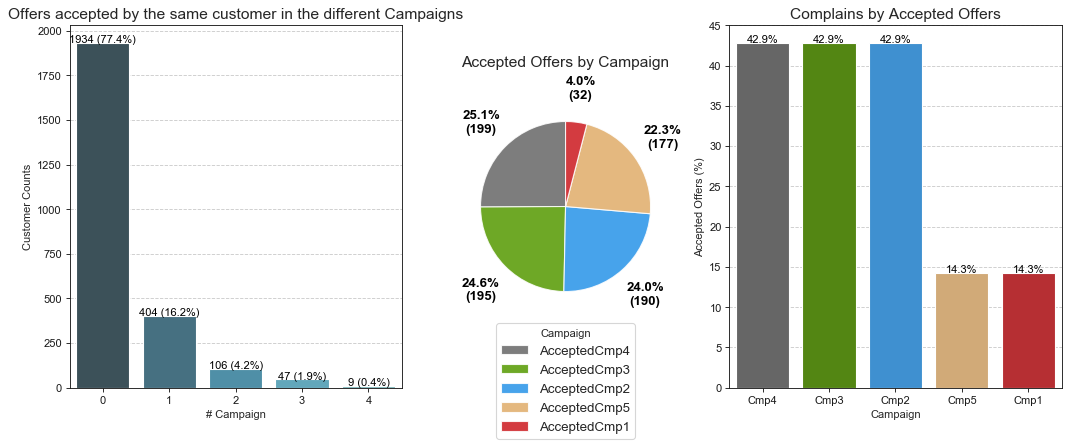

In [12]:
figCampains = f_campaigns_analysis(df)
plt.show(figCampains)

<a class="anchor" id="campaigns-ki"></a>
<b>Key Insights</b>:
   >The majority of the customers did not accept any offer during the previous campaigns and the results from the different previous campaigns are not that different (apart from the first one which the acceptance rate is lower than the subsequent ones).
   >
   >Additionally, there are even fewer customers that have accepted more than one offer in different campaigns, so this means that the customers are not keen to repeat their experience. Could this mean that they are not happy? 
   >
   >We decided then to look at the complains from the previous campaigns and we can notice that in campaigns 2, 3 and 4 the complain rate is quite high (over 40%).
   >
   >So, this tell us that there is room to improve the effectiveness of the campaigns in the future. Is the company targeting the customers to present the offers to, or is just presenting the offers to all type of customers?

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="data-preparation"></a>
# 3. Data Preparation
<a class="anchor" id="clean-the-data"></a>
### 3.1: Clean the data

In this section we will reproduce the steps already taken in the Segmentation problem (for details please check this <a href = "Project_Segmentation.ipynb">link</a>).


<a class="anchor" id="inconsistent_records"></a>
#### 3.1.1: Drop inconsistent records

In [13]:
df_treated = df.copy()
nrecords_original = np.shape(df_treated)[0]
df_treated = df_treated[df_treated['MntTotal'] < df_treated['Income']]

- `Total Expenditure` vs `TotalPurchases`

In [14]:
df_treated = df_treated[((df_treated['MntTotal'] > 0) & (df_treated['TotalPurchases'] > 0))]

- `NumWebPurchases` vs `NumWebVisitsMonth`

In [15]:
df_treated = df_treated[(((df_treated['NumWebPurchases'] > 0) & (df_treated['NumWebVisitsMonth'] > 0)) | \
                    ((df_treated['NumWebPurchases'] == 0) & (df_treated['NumWebVisitsMonth'] >= 0)))]

<a class="anchor" id="outliers"></a>
#### 3.1.2: Remove outliers

In [16]:
# drop records where Income > 200 k 
df_treated = df_treated[df_treated['Income'] < 200000]   
df_treated = df_treated[df_treated['NumWebVisitsMonth'] < 15]
df_treated = df_treated[df_treated['NumCatalogPurchases'] < 20]

In [17]:
dropped = nrecords_original - np.shape(df_treated)[0]
print('total dropped rows: ' + str('{:.1f}%'.format(dropped / nrecords_original * 100)))

total dropped rows: 2.8%


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="transform-the-data"></a>
### 3.2: Transform the data
<a class="anchor" id="transform-normality"></a>
#### 3.2.1: Transformations to archieve "normality"

The following lines will reproduce the analysis already made in the Segmentation problem (for details please check this <a href = "Project_Segmentation.ipynb">link</a>).

- Product Usage (correct for the highly right skewed distributions)

In [18]:
# Use Box-Cox Transformations (the lambda coefficients were obtained by searching 
# the one that maximizes the log-likelihood function)
var_list = ['MntTechnical', 'MntRomance', 'MntAdventure', 'MntTravelling', 'MntHistory', 'MntHardcover']

for index, item in enumerate(var_list):
    var_aux = eval('df_treated[' + '\'' + item + '\'' + ']') + 0.1
    boxcox_out = sp.stats.boxcox(var_aux)
    lmbda = '{:.3f}'.format(boxcox_out[1])
    exec('df_treated.loc[:, ' + '\'' + item + '_z' + '\'' + '] = var_aux.map(lambda x: (x**' + lmbda +\
         ' - 1) / ' + lmbda + ')')
df_treated.head(n = 5)

,Custid,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntTechnical,MntRomance,MntAdventure,MntTravelling,MntHistory,MntHardcover,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Complain,Z_CostContact,Z_Revenue,DepVar,Age,MntTotal,AgeBins,TotalPurchases,MntTechnical_z,MntRomance_z,MntAdventure_z,MntTravelling_z,MntHistory_z,MntHardcover_z
0,100003119,1963,PhD,Divorced,102929,0,1,2015-07-22,10,5320,1760,2520,1060,880,133,3,9,4,13,5,0,0,0,0,0,0,3,16,0,56,11540,"(55, 60]",29,29.480992,17.368671,12.259885,15.074638,14.643880,8.965673
1,100003134,1953,Master,Married,120449,0,0,2015-10-31,75,5320,2520,7350,2520,2520,126,1,7,6,11,1,0,0,1,0,0,0,3,16,0,66,20230,"(65, 70]",25,29.480992,19.040225,14.881761,18.854585,19.322776,8.802696
2,100003152,1974,PhD,Together,55318,1,0,2014-11-24,31,90,0,90,60,20,5,1,3,1,2,9,0,0,0,0,0,0,3,16,0,45,260,"(40, 45]",7,8.235585,-1.843253,5.781866,6.328719,4.139151,1.971364
3,100003155,1974,Graduation,Married,40732,1,0,2016-03-16,30,50,140,210,0,100,7,1,3,1,3,6,0,0,0,0,0,0,3,16,0,45,500,"(40, 45]",8,6.581903,8.459886,7.216321,-1.847177,7.642684,2.468718
4,100003158,1962,Graduation,Divorced,22048,0,0,2016-04-16,37,0,80,75,80,0,4,1,3,1,3,3,0,0,0,0,0,0,3,16,0,57,235,"(55, 60]",8,-1.757949,7.031864,5.489962,6.996683,-1.837389,1.663140


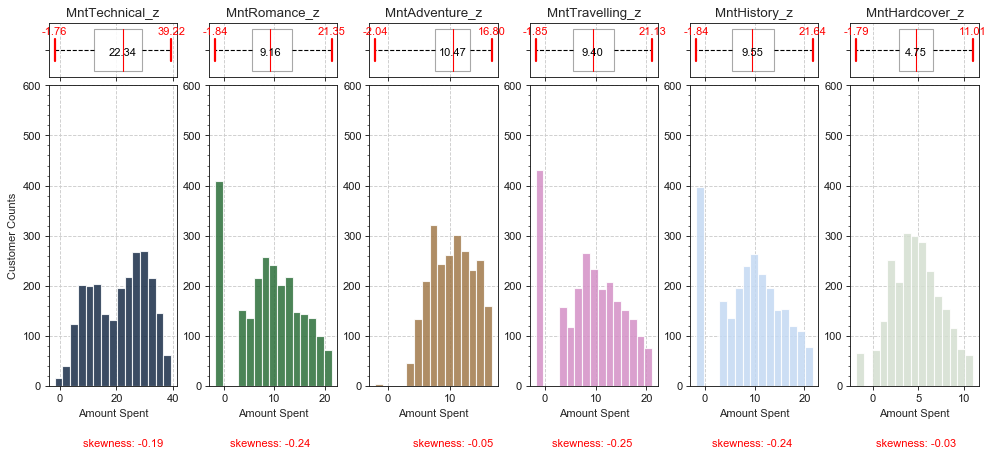

In [19]:
var_list = ['MntTechnical_z', 'MntRomance_z', 'MntAdventure_z', 'MntTravelling_z', 'MntHistory_z']
color_list = [Usages_color_dict.get(value) for value in list_Usage]
var_list.append('MntHardcover_z')
color_list.append('#d4ded0')
max_list = [600, 600, 600, 600, 600, 600]

figTransform_prodUsage = f_transformHist_analysis(df_treated, var_list , color_list, max_list)
plt.show(figTransform_prodUsage)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="flag-variables"></a>
#### 3.2.2: Create flag variables

- Nominal Variables

In [20]:
# Education
list_bin = [1 if value == 'Basic' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_Basic_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == '2n Cycle' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_2nCycle_flag' + '\'' + '] = list_bin')  

list_bin = [1 if value == 'Graduation' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_Graduation_flag' + '\'' + '] = list_bin')  

list_bin = [1 if value == 'Master' else 0 for value in eval('df_treated[' + '\'' + 'Education' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Education_Master_flag' + '\'' + '] = list_bin')  


# Marital_Status
list_bin = [1 if value == 'Single' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Single_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 'Widow' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Widow_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 'Divorced' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Divorced_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 'Together' else 0 for value in eval('df_treated[' + '\'' + 'Marital_Status' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'MStatus_Together_flag' + '\'' + '] = list_bin')


# Kidhome
list_bin = [1 if value == 0 else 0 for value in eval('df_treated[' + '\'' + 'Kidhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Kidhome_0_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 1 else 0 for value in eval('df_treated[' + '\'' + 'Kidhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Kidhome_1_flag' + '\'' + '] = list_bin')


# Teenhome
list_bin = [1 if value == 0 else 0 for value in eval('df_treated[' + '\'' + 'Teenhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Teenhome_0_flag' + '\'' + '] = list_bin')

list_bin = [1 if value == 1 else 0 for value in eval('df_treated[' + '\'' + 'Teenhome' + '\'' + ']')]
exec('df_treated.loc[:, ' + '\'' + 'Teenhome_1_flag' + '\'' + '] = list_bin')

In [21]:
df_treated.head(n = 5)

,Custid,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntTechnical,MntRomance,MntAdventure,MntTravelling,MntHistory,MntHardcover,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Complain,Z_CostContact,Z_Revenue,DepVar,Age,MntTotal,AgeBins,TotalPurchases,MntTechnical_z,MntRomance_z,MntAdventure_z,MntTravelling_z,MntHistory_z,MntHardcover_z,Education_Basic_flag,Education_2nCycle_flag,Education_Graduation_flag,Education_Master_flag,MStatus_Single_flag,MStatus_Widow_flag,MStatus_Divorced_flag,MStatus_Together_flag,Kidhome_0_flag,Kidhome_1_flag,Teenhome_0_flag,Teenhome_1_flag
0,100003119,1963,PhD,Divorced,102929,0,1,2015-07-22,10,5320,1760,2520,1060,880,133,3,9,4,13,5,0,0,0,0,0,0,3,16,0,56,11540,"(55, 60]",29,29.480992,17.368671,12.259885,15.074638,14.643880,8.965673,0,0,0,0,0,0,1,0,1,0,0,1
1,100003134,1953,Master,Married,120449,0,0,2015-10-31,75,5320,2520,7350,2520,2520,126,1,7,6,11,1,0,0,1,0,0,0,3,16,0,66,20230,"(65, 70]",25,29.480992,19.040225,14.881761,18.854585,19.322776,8.802696,0,0,0,1,0,0,0,0,1,0,1,0
2,100003152,1974,PhD,Together,55318,1,0,2014-11-24,31,90,0,90,60,20,5,1,3,1,2,9,0,0,0,0,0,0,3,16,0,45,260,"(40, 45]",7,8.235585,-1.843253,5.781866,6.328719,4.139151,1.971364,0,0,0,0,0,0,0,1,0,1,1,0
3,100003155,1974,Graduation,Married,40732,1,0,2016-03-16,30,50,140,210,0,100,7,1,3,1,3,6,0,0,0,0,0,0,3,16,0,45,500,"(40, 45]",8,6.581903,8.459886,7.216321,-1.847177,7.642684,2.468718,0,0,1,0,0,0,0,0,0,1,1,0
4,100003158,1962,Graduation,Divorced,22048,0,0,2016-04-16,37,0,80,75,80,0,4,1,3,1,3,3,0,0,0,0,0,0,3,16,0,57,235,"(55, 60]",8,-1.757949,7.031864,5.489962,6.996683,-1.837389,1.663140,0,0,1,0,0,0,1,0,1,0,1,0


- Transformed Variables

In [22]:
# Create flag variables for the Transformed Variables (whenever required based on the previous analysis)
var_list = ['MntRomance_z', 'MntTravelling_z', 'MntHistory_z']
for index, item in enumerate(var_list):
    list_bin = []
    list_bin = [0 if value < 0 else 1 for value in eval('df_treated[' + '\'' + item + '\'' + ']')]
    exec('df_treated.loc[:, ' + '\'' + item.split('_')[0] + '_flag' + '\'' + '] = list_bin')

In [23]:
df_treated.head(n = 5)

,Custid,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntTechnical,MntRomance,MntAdventure,MntTravelling,MntHistory,MntHardcover,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Complain,Z_CostContact,Z_Revenue,DepVar,Age,MntTotal,AgeBins,TotalPurchases,MntTechnical_z,MntRomance_z,MntAdventure_z,MntTravelling_z,MntHistory_z,MntHardcover_z,Education_Basic_flag,Education_2nCycle_flag,Education_Graduation_flag,Education_Master_flag,MStatus_Single_flag,MStatus_Widow_flag,MStatus_Divorced_flag,MStatus_Together_flag,Kidhome_0_flag,Kidhome_1_flag,Teenhome_0_flag,Teenhome_1_flag,MntRomance_flag,MntTravelling_flag,MntHistory_flag
0,100003119,1963,PhD,Divorced,102929,0,1,2015-07-22,10,5320,1760,2520,1060,880,133,3,9,4,13,5,0,0,0,0,0,0,3,16,0,56,11540,"(55, 60]",29,29.480992,17.368671,12.259885,15.074638,14.643880,8.965673,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1
1,100003134,1953,Master,Married,120449,0,0,2015-10-31,75,5320,2520,7350,2520,2520,126,1,7,6,11,1,0,0,1,0,0,0,3,16,0,66,20230,"(65, 70]",25,29.480992,19.040225,14.881761,18.854585,19.322776,8.802696,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1
2,100003152,1974,PhD,Together,55318,1,0,2014-11-24,31,90,0,90,60,20,5,1,3,1,2,9,0,0,0,0,0,0,3,16,0,45,260,"(40, 45]",7,8.235585,-1.843253,5.781866,6.328719,4.139151,1.971364,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1
3,100003155,1974,Graduation,Married,40732,1,0,2016-03-16,30,50,140,210,0,100,7,1,3,1,3,6,0,0,0,0,0,0,3,16,0,45,500,"(40, 45]",8,6.581903,8.459886,7.216321,-1.847177,7.642684,2.468718,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1
4,100003158,1962,Graduation,Divorced,22048,0,0,2016-04-16,37,0,80,75,80,0,4,1,3,1,3,3,0,0,0,0,0,0,3,16,0,57,235,"(55, 60]",8,-1.757949,7.031864,5.489962,6.996683,-1.837389,1.663140,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="normalize-the-data"></a>
### 3.3: Normalize the data 

In [24]:
# Filter out the columns to apply the normalization
df_treated = df_treated.assign(Age_z = df_treated['Age'].values)
df_treated = df_treated.assign(Income_z = df_treated['Income'].values)
df_treated = df_treated.assign(MntTotal_z = df_treated['MntTotal'].values)
df_treated = df_treated.assign(NumCatalogPurchases_z = df_treated['NumCatalogPurchases'].values)
df_treated = df_treated.assign(NumStorePurchases_z = df_treated['NumStorePurchases'].values)
df_treated = df_treated.assign(NumWebPurchases_z = df_treated['NumWebPurchases'].values)
df_treated = df_treated.assign(NumDealsPurchases_z = df_treated['NumDealsPurchases'].values)
df_treated = df_treated.assign(TotalPurchases_z = df_treated['TotalPurchases'].values)
df_treated = df_treated.assign(NumWebVisitsMonth_z = df_treated['NumWebVisitsMonth'].values)
df_treated = df_treated.assign(Recency_z = df_treated['Recency'].values)

df_treated_z = df_treated[df_treated.columns[pd.Series(df_treated.columns).str.contains('_z')]]

In [25]:
df_treated_z.head(n = 5)

,MntTechnical_z,MntRomance_z,MntAdventure_z,MntTravelling_z,MntHistory_z,MntHardcover_z,Age_z,Income_z,MntTotal_z,NumCatalogPurchases_z,NumStorePurchases_z,NumWebPurchases_z,NumDealsPurchases_z,TotalPurchases_z,NumWebVisitsMonth_z,Recency_z
0,29.480992,17.368671,12.259885,15.074638,14.643880,8.965673,56,102929,11540,4,13,9,3,29,5,10
1,29.480992,19.040225,14.881761,18.854585,19.322776,8.802696,66,120449,20230,6,11,7,1,25,1,75
2,8.235585,-1.843253,5.781866,6.328719,4.139151,1.971364,45,55318,260,1,2,3,1,7,9,31
3,6.581903,8.459886,7.216321,-1.847177,7.642684,2.468718,45,40732,500,1,3,3,1,8,6,30
4,-1.757949,7.031864,5.489962,6.996683,-1.837389,1.663140,57,22048,235,1,3,3,1,8,3,37


In [26]:
# Apply the Min-Max Normalization
df_treated_z = df_treated_z.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
df_treated_z.describe().T

,count,mean,std,min,25%,50%,75%,max
MntTechnical_z,2431.0,0.554518,0.238105,0.0,0.342223,0.588062,0.753138,1.0
MntRomance_z,2431.0,0.465019,0.276429,0.0,0.315435,0.474208,0.665368,1.0
MntAdventure_z,2431.0,0.662335,0.180196,0.0,0.509764,0.664206,0.809847,1.0
MntTravelling_z,2431.0,0.465234,0.280904,0.0,0.317624,0.489498,0.671720,1.0
MntHistory_z,2431.0,0.468447,0.276398,0.0,0.312897,0.484992,0.668756,1.0
MntHardcover_z,2431.0,0.511188,0.213923,0.0,0.363999,0.511110,0.657796,1.0
Age_z,2431.0,0.497160,0.211535,0.0,0.333333,0.491228,0.666667,1.0
Income_z,2431.0,0.475794,0.216587,0.0,0.299316,0.479216,0.650920,1.0
MntTotal_z,2431.0,0.225963,0.228493,0.0,0.023303,0.142554,0.383407,1.0
NumCatalogPurchases_z,2431.0,0.247859,0.255598,0.0,0.090909,0.181818,0.363636,1.0


In [27]:
df_treated[df_treated.columns[pd.Series(df_treated.columns).str.contains('_z')]] = df_treated_z
df_treated.head(n = 5)

,Custid,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntTechnical,MntRomance,MntAdventure,MntTravelling,MntHistory,MntHardcover,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,Complain,Z_CostContact,Z_Revenue,DepVar,Age,MntTotal,AgeBins,TotalPurchases,MntTechnical_z,MntRomance_z,MntAdventure_z,MntTravelling_z,MntHistory_z,MntHardcover_z,Education_Basic_flag,Education_2nCycle_flag,Education_Graduation_flag,Education_Master_flag,MStatus_Single_flag,MStatus_Widow_flag,MStatus_Divorced_flag,MStatus_Together_flag,Kidhome_0_flag,Kidhome_1_flag,Teenhome_0_flag,Teenhome_1_flag,MntRomance_flag,MntTravelling_flag,MntHistory_flag,Age_z,Income_z,MntTotal_z,NumCatalogPurchases_z,NumStorePurchases_z,NumWebPurchases_z,NumDealsPurchases_z,TotalPurchases_z,NumWebVisitsMonth_z,Recency_z
0,100003119,1963,PhD,Divorced,102929,0,1,2015-07-22,10,5320,1760,2520,1060,880,133,3,9,4,13,5,0,0,0,0,0,0,3,16,0,56,11540,"(55, 60]",29,0.762382,0.828315,0.759004,0.736522,0.702152,0.840329,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,0.631579,0.662146,0.348717,0.272727,1.000000,0.636364,0.214286,0.666667,0.444444,0.101010
1,100003134,1953,Master,Married,120449,0,0,2015-10-31,75,5320,2520,7350,2520,2520,126,1,7,6,11,1,0,0,1,0,0,0,3,16,0,66,20230,"(65, 70]",25,0.762382,0.900383,0.898159,0.901044,0.901487,0.827600,0,0,0,1,0,0,0,0,1,0,1,0,1,1,1,0.807018,0.788339,0.612570,0.454545,0.818182,0.454545,0.071429,0.545455,0.000000,0.757576
2,100003152,1974,PhD,Together,55318,1,0,2014-11-24,31,90,0,90,60,20,5,1,3,1,2,9,0,0,0,0,0,0,3,16,0,45,260,"(40, 45]",7,0.243891,0.000000,0.415187,0.355856,0.254619,0.294038,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0.438596,0.319213,0.006224,0.000000,0.000000,0.090909,0.071429,0.000000,0.888889,0.313131
3,100003155,1974,Graduation,Married,40732,1,0,2016-03-16,30,50,140,210,0,100,7,1,3,1,3,6,0,0,0,0,0,0,3,16,0,45,500,"(40, 45]",8,0.203533,0.444216,0.491320,0.000000,0.403880,0.332884,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0.438596,0.214153,0.013511,0.000000,0.090909,0.090909,0.071429,0.030303,0.555556,0.303030
4,100003158,1962,Graduation,Divorced,22048,0,0,2016-04-16,37,0,80,75,80,0,4,1,3,1,3,3,0,0,0,0,0,0,3,16,0,57,235,"(55, 60]",8,0.000000,0.382647,0.399694,0.384929,0.000000,0.269964,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0.649123,0.079576,0.005465,0.000000,0.090909,0.090909,0.071429,0.030303,0.222222,0.373737


[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="modelling"></a>
# 4. Modelling

<b>Output Variable</b>: `DepVar`.

For the modelling we did not use the variable `Complain` since this is only known in the past (the complains will only occur after the offers are accepted by the customers).

Additionally to avoid inducing noise in the models, we were careful in using the variables `TotalPurchases` and `MntTotal` derived by us from the sum of the respective terms, so they were only used when not all of the individual term variables were used.

<b>Models</b>: We have tested the following types of predictive models: K-Nearest Neighbors, Naive Bayes and Neural Networks.

<b>Sampling technique</b>: Considering that the dataset is not that large (only 2431 records after the Data Preparation step) we decided to use the stratified k-fold cross validation with k = 5 to ensure a testing subset large enough to avoid excessive error variance. With this technique we aim at accessing the model stability and avoid overfitting.

In [28]:
df_predictive = df_treated.copy()
DepVar_0 = df_predictive[df_predictive['DepVar'] == 0]['DepVar'].count()
print('DepVar[0]: ', DepVar_0)
DepVar_1 = df_predictive[df_predictive['DepVar'] == 1]['DepVar'].count()
print('DepVar[1]: ', DepVar_1)

DepVar[0]:  2119
DepVar[1]:  312


We can notice that the dataset is very unbalanced towards the class 1 of `DepVar` (the customer accepted the marketing offer).

In this context we need to consider that there are different costs associated to the erroneous predictions that the model could make:

- there is a missing net profit opportunity of 13 €/customer (revenue: 16 € | cost: 3 €) for each False Negative (FN)
- there is a cost of 3 €/customer for each False Positive (FP)

So, we can define the cost matrix represented below:

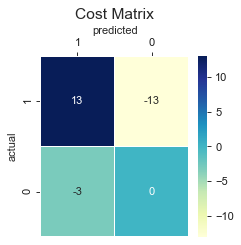

In [29]:
c_11 = 13 # this is the net profit made when the model prediction is accurate
c_10 = -13 # this is the cost of failing the prediction when the customer would accept the offer
c_01 = -3 # this is the cost failing the prediction when the customer would not accept the offer
c_00 = 0 # there is no cost if the model accuratly predicts that the customer would not accept

cost_matrix = np.array([[c_00, c_01], [c_10, c_11]])

figcost_matrix, ax_cost_matrix = plt.subplots(figsize = (3, 3), dpi = 80, facecolor = 'w', edgecolor = 'k',\
                             constrained_layout = False)

sns.heatmap(cost_matrix,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = -13, vmax = 13,\
                    linewidths = .5, cbar = True, ax = ax_cost_matrix).set_title('Cost Matrix', size = 14)

ax_cost_matrix.invert_xaxis()
ax_cost_matrix.invert_yaxis()
ax_cost_matrix.set_xlabel('predicted')
ax_cost_matrix.set_ylabel('actual')
ax_cost_matrix.xaxis.set_ticks_position('top')
ax_cost_matrix.xaxis.set_label_position('top')

plt.show(figcost_matrix)

In [30]:
theoretical_threshold = (cost_matrix[0, 1] - cost_matrix[0, 0])/\
(cost_matrix[0, 1] - cost_matrix[1, 1] + cost_matrix[1, 0] - cost_matrix[0, 0])
print('theoretical threshold: ', theoretical_threshold)

theoretical threshold:  0.10344827586206896


Since the models by default use a cutoff value of 0.5 which in this case is far away from the theoretical threshold evaluated above and only the Naive-Bayes has the possibility of sample weighting, we decided to implement the thresholding on all of the models by applying a custom function `f_model_pred_cost(model_in, X_in, threshold_in)`, <a href='f_model_pred_cost'>see link</a>, after returning the probability estimated for the input X vector (this refers to the `predict_proba` method of the models in the scikit phyton library).

To check if this threshold is adequate, for each fold from the cross-validation technique and each tested model, we decided to check how was the profit of the previous campaigns if the models were to be used for both the train and test datasets. The profit was calculated using the costs from the matrix above (which implies that it does not refer to the actual profit but instead to the adjusted profit in case the model did not make any erroneous predictions). With this approach we ensure that this metric has a constant reference (ideal model) so we can easily compare the values across the different models tested and, in fact, the actual profit will be higher since the FN would have a true cost of only 3 and not 13 (opportunity cost).

$$ Adjusted Profit = 13.TP - 13.FN - 3.FP $$

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="feature-importance"></a>
### 4.1: Feature Importance (Decision Tree Classifier)

In [31]:
# Import the required libraries
from scipy import interp

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [32]:
list_vars = df_predictive.columns[pd.Series(df_predictive.columns).str.contains('_z') |\
                             pd.Series(df_predictive.columns).str.contains('_flag')]
print(list_vars)

Index(['MntTechnical_z', 'MntRomance_z', 'MntAdventure_z', 'MntTravelling_z',
       'MntHistory_z', 'MntHardcover_z', 'Education_Basic_flag',
       'Education_2nCycle_flag', 'Education_Graduation_flag',
       'Education_Master_flag', 'MStatus_Single_flag', 'MStatus_Widow_flag',
       'MStatus_Divorced_flag', 'MStatus_Together_flag', 'Kidhome_0_flag',
       'Kidhome_1_flag', 'Teenhome_0_flag', 'Teenhome_1_flag',
       'MntRomance_flag', 'MntTravelling_flag', 'MntHistory_flag', 'Age_z',
       'Income_z', 'MntTotal_z', 'NumCatalogPurchases_z',
       'NumStorePurchases_z', 'NumWebPurchases_z', 'NumDealsPurchases_z',
       'TotalPurchases_z', 'NumWebVisitsMonth_z', 'Recency_z'],
      dtype='object')


In [33]:
target = df_predictive['DepVar']
data = df_predictive[list_vars]

In [34]:
# Use a Decision Tree Classifier for Feature Selection
modelDT = DecisionTreeClassifier()
modelDT.fit(X = data, y = target)
modelDT.feature_importances_

array([0.03064713, 0.03333994, 0.14308398, 0.03804034, 0.0242499 ,
       0.03442056, 0.        , 0.        , 0.00245137, 0.00351718,
       0.00984924, 0.00270765, 0.00768002, 0.01476948, 0.00951098,
       0.00490273, 0.        , 0.        , 0.00112062, 0.        ,
       0.00306421, 0.03157884, 0.07874635, 0.03158276, 0.08706022,
       0.04377667, 0.02681263, 0.05194521, 0.05470287, 0.06739235,
       0.16304679])

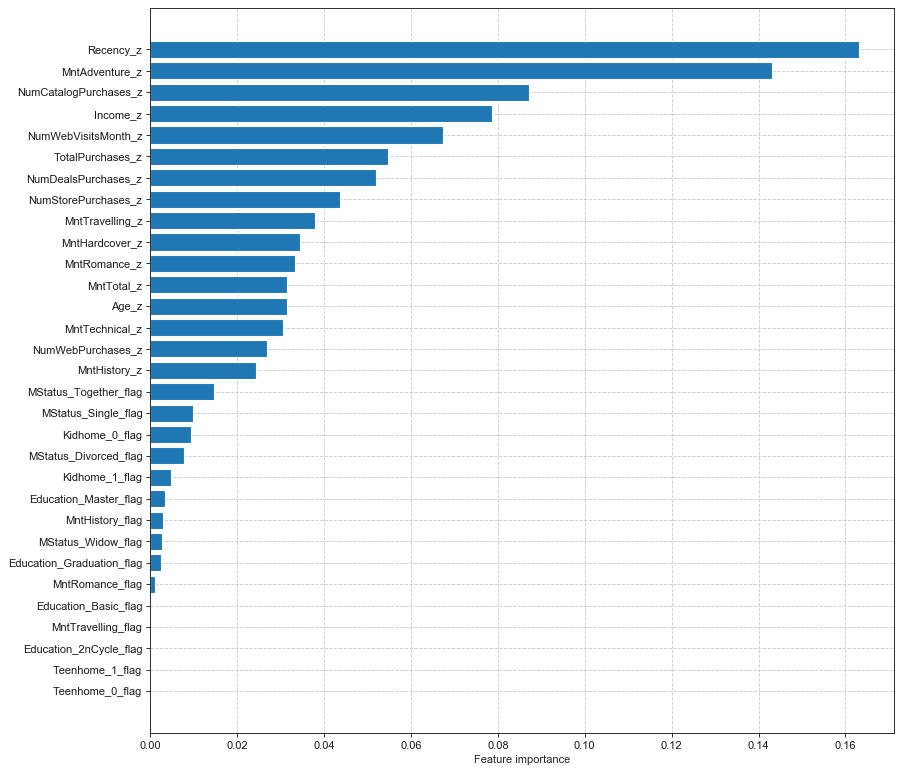

In [35]:
plot_feature_importances_tugas(modelDT, data)
plt.show()

Somehow we can observe that there are 5 groups of features according to their relevance as returned by the decision tree classifier:

- <b>Group 1</b> (most relevant features): `Recency_z`, `MntAdventure_z`;
- <b>Group 2</b> (next most relevant features): `NumCatalogPurchases_z`, `Income_z`, `NumWebVisitsMonth_z`;
- <b>Group 3</b> (next most relevant features): `NumDealsPurchases_z`, `MntTechnical_z`, `MntHardcover_z`, `MntTravelling_z`, `NumStorePurchases_z`, `TotalPurchases_z`, `MntTotal_z`, `MntRomance_z`, `Age_z`, `MntHistory_z`
- <b>Group 4</b> (next most relevant features): `NumWebPurchases_z`, `MStatus_Together_flag`, `MStatus_Single_flag`, `Kidhome_0_flag`, `Kidhome_1_flag`, `MntTravelling_flag`, `MStatus_Divorced_flag`, `Education_Graduation_flag`, 
`MStatus_Widow_flag`, `MntRomance_flag`
- <b>Group 5</b> (no relevance): `Education_Master_flag`, `Education_2nCycle_flag`, `Education_Basic_flag`, `Teenhome_0_flag`, `Teenhome_1_flag`, `MntHistory_flag`

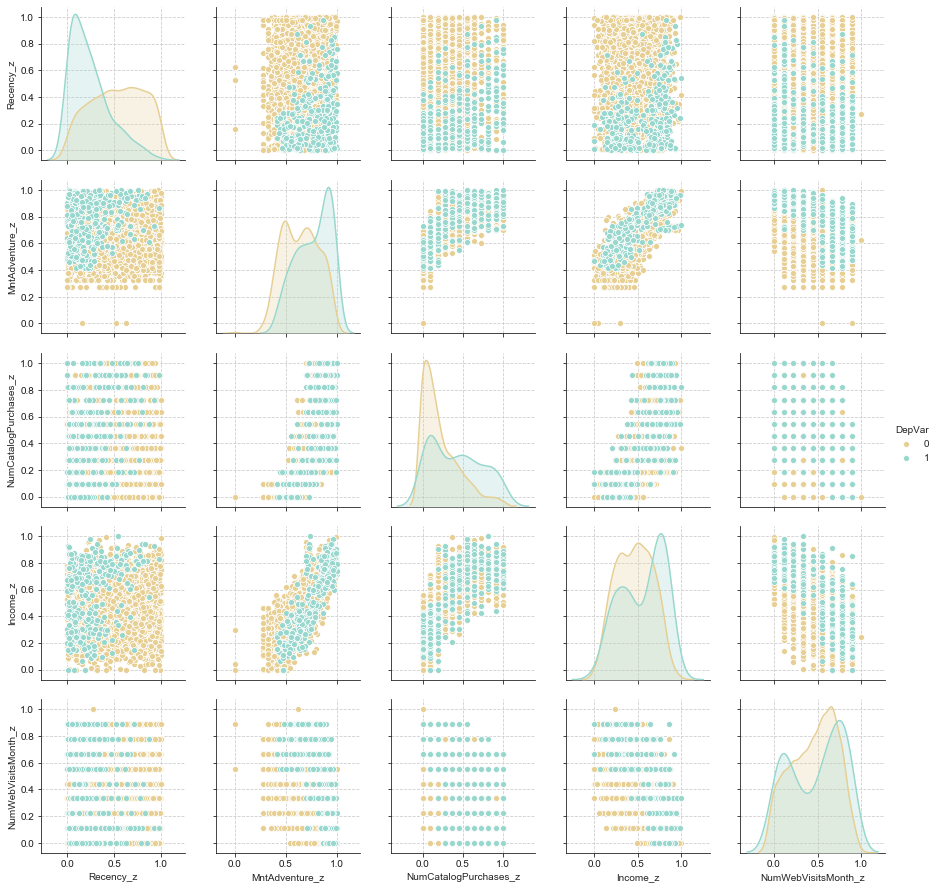

In [36]:
DepVar_color_palette = sns.color_palette('BrBG', 2)

list_vars = ['Recency_z', 'MntAdventure_z', 'NumCatalogPurchases_z', 'Income_z', 'NumWebVisitsMonth_z']
fig_features = f_feature_analysis(list_vars, df_treated, DepVar_color_palette)
plt.show(fig_features)

From the pairplot of the variables included on Group 1 and 2 it is possible to observe (on the histograms) that for each variable there is a different distribution for between the classes 0/1 of `DepVar` which can help explaining the results from the Decision Tree classifier.

[Return to Table of Contents](#Table_Contents)

In [37]:
# build some list to append the model metrics (for model comparison afterwards)
model_cmp = []
model_cmp_type = []
model_cmp_mean_auc = []
model_cmp_mean_f1_score_train_0 = []
model_cmp_mean_f1_score_test_0 = []
model_cmp_mean_f1_score_train_1 = []
model_cmp_mean_f1_score_test_1 = []
model_cmp_total_profit_train = []
model_cmp_total_profit_test = []

<a class="anchor" id="simplified-model"></a>
### 4.2: Simplified Model

<b>Input Variables (Group 1)</b>: `Recency_z`, `MntAdventure_z`

In [38]:
list_vars = ['Recency_z', 'MntAdventure_z']
nvars = len(list_vars)

<a class="anchor" id="simplified-model-sampling"></a>
#### 4.2.1: Sampling (Stratified k-Fold Cross-Validation)

In [39]:
target = df_predictive['DepVar'].values
data = df_predictive[list_vars].values

skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(target, data)

cv = 0
for train_index, test_index in skf.split(data, target):
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    cv = cv + 1

n_cv = cv

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="simplified-model-kmeans"></a>
#### 4.2.2: K-Nearest Neighbours

In [40]:
model_cmp.append(nvars)
model_cmp_type.append('KNN')

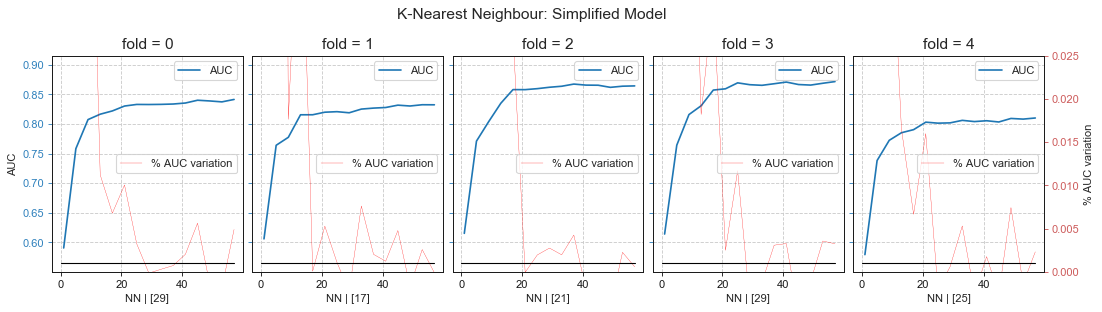

In [41]:
# test k NN (number of Nearest Neighbours)
figmodelKNNs = f_model_KNN_test(60, 4, 'K-Nearest Neighbour: Simplified Model')
plt.show(figmodelKNNs)

Looking at these plots let's choose K = 30.

In [42]:
k = 30

In [43]:
# build the models (only for the best NN)
for cv in range(n_cv): 
    exec('modelKNN_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('modelKNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

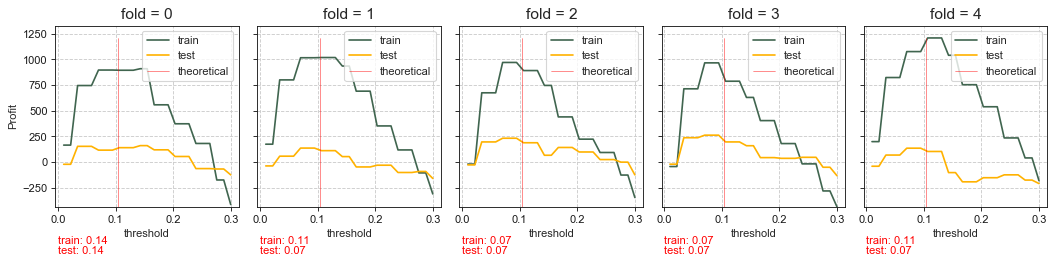

In [44]:
# plot the profit vs threshold
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold_profit('KNN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelKNNs_thresholds)

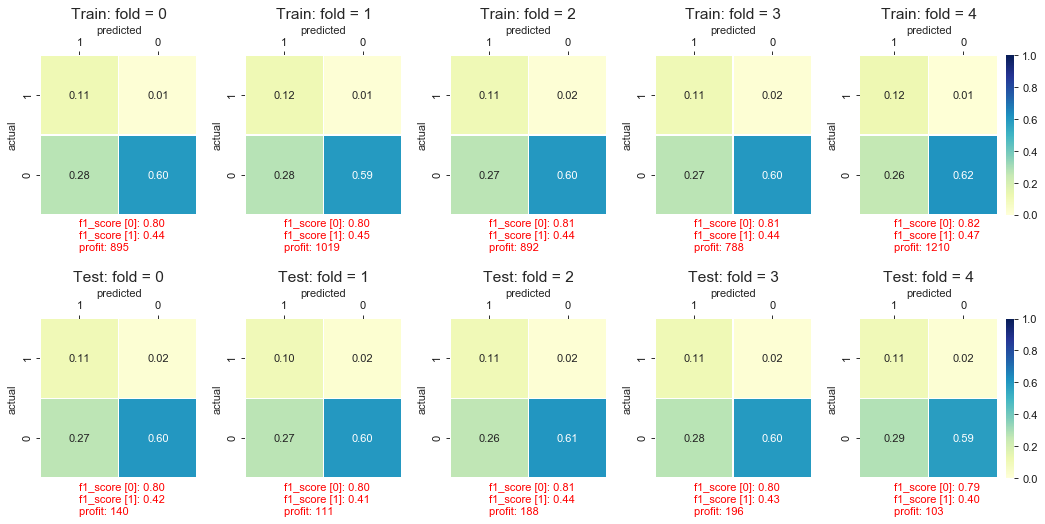

In [45]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelKNNs_CM, f1_score_train_KNNs, f1_score_test_KNNs, profit_train_KNNs, profit_test_KNNs = \
f_CM_heatmap('KNN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_KNNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_KNNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_KNNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_KNNs[1])
model_cmp_total_profit_train.append(sum(profit_train_KNNs))
model_cmp_total_profit_test.append(sum(profit_test_KNNs))

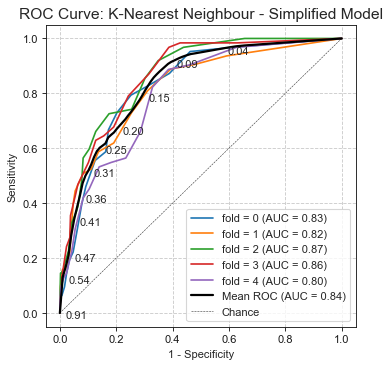

In [46]:
# plot the ROC Curve
figmodelKNNs_ROC, KNNs_mean_auc = f_ROC_Curve('KNN', n_cv, nvars, 'ROC Curve: K-Nearest Neighbour - Simplified Model')
plt.show(figmodelKNNs_ROC)
model_cmp_mean_auc.append(KNNs_mean_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="simplified-model-naivebayes"></a>
#### 4.2.3: Naive Bayes

In [47]:
model_cmp.append(nvars)
model_cmp_type.append('NaiveBayes')

In [48]:
# build the models
for cv in range(n_cv): 
    exec('modelNB_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('modelNB_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

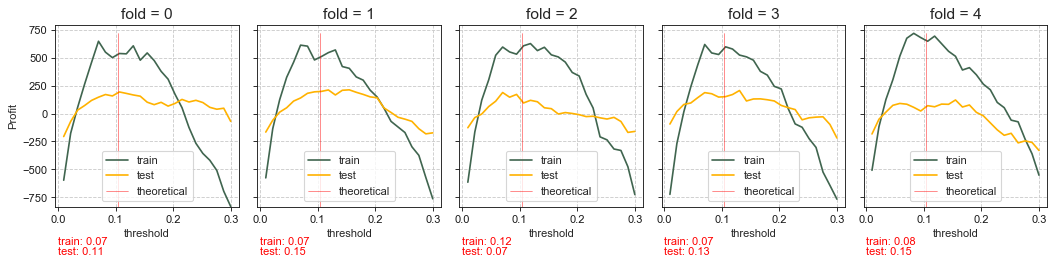

In [49]:
# plot the profit vs threshold
figmodelNBs_thresholds, NBs_best_threshold_train, NBs_best_threshold_test = \
f_threshold_profit('NB', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNBs_thresholds)

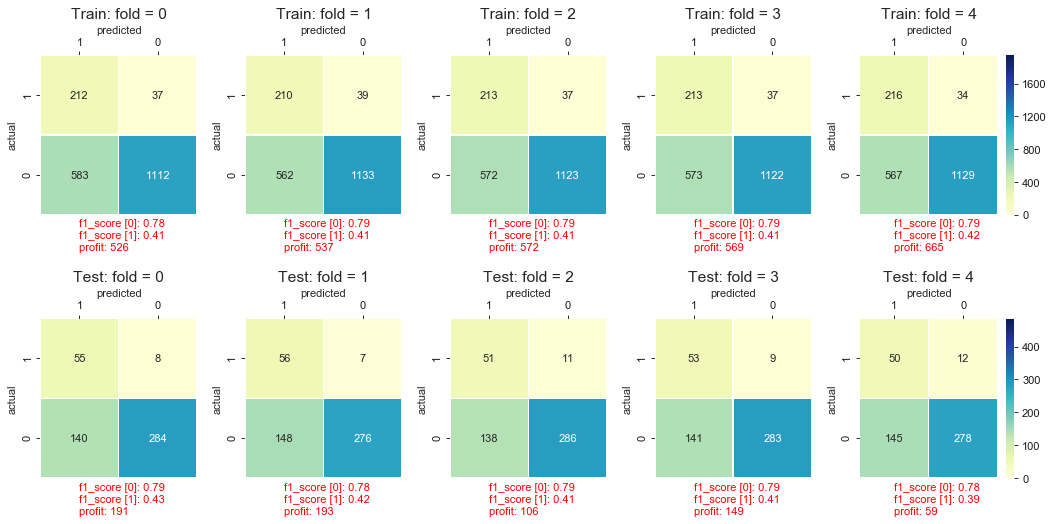

In [50]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNBs_CM, f1_score_train_NBs, f1_score_test_NBs, profit_train_NBs, profit_test_NBs = \
f_CM_heatmap('NB', n_cv, nvars, theoretical_threshold, False)
plt.show(figmodelNBs_CM)

As the sample weighing is available for this model we decided to check how our thresholding process is behaving comparatively (considering only the fold 0 of the cross validation technique).

In [51]:
# confirm if the thresholding process is in accordance to the sample weighting available in the Naive Bayes model
train_sample_weight_0 = [((1-theoretical_threshold)/theoretical_threshold) if value > 0 else 1 for value in y_train_0]
test_sample_weight_0 = [((1-theoretical_threshold)/theoretical_threshold) if value > 0 else 1 for value in y_test_0]

modelNB_0_weighted = GaussianNB()
modelNB_0_weighted.fit(X_train_0, y_train_0, sample_weight = train_sample_weight_0)

pred_train_NB_0_weighted = modelNB_0_weighted.predict(X = X_train_0)
pred_test_NB_0_weighted = modelNB_0_weighted.predict(X = X_test_0)

print('Train:')
print(confusion_matrix(y_train_0, pred_train_NB_0_weighted))
print(classification_report(y_train_0, pred_train_NB_0_weighted))

print('Test:')
print(confusion_matrix(y_test_0, pred_test_NB_0_weighted))
print(classification_report(y_test_0, pred_test_NB_0_weighted))

Train:
[[1112  583]
 [  37  212]]
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      1695
           1       0.27      0.85      0.41       249

    accuracy                           0.68      1944
   macro avg       0.62      0.75      0.59      1944
weighted avg       0.88      0.68      0.73      1944

Test:
[[284 140]
 [  8  55]]
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       424
           1       0.28      0.87      0.43        63

    accuracy                           0.70       487
   macro avg       0.63      0.77      0.61       487
weighted avg       0.88      0.70      0.75       487



Comparing the output from the sample weighting with our thresholding process it is possible to observe a match on the results which means that our process is ok.

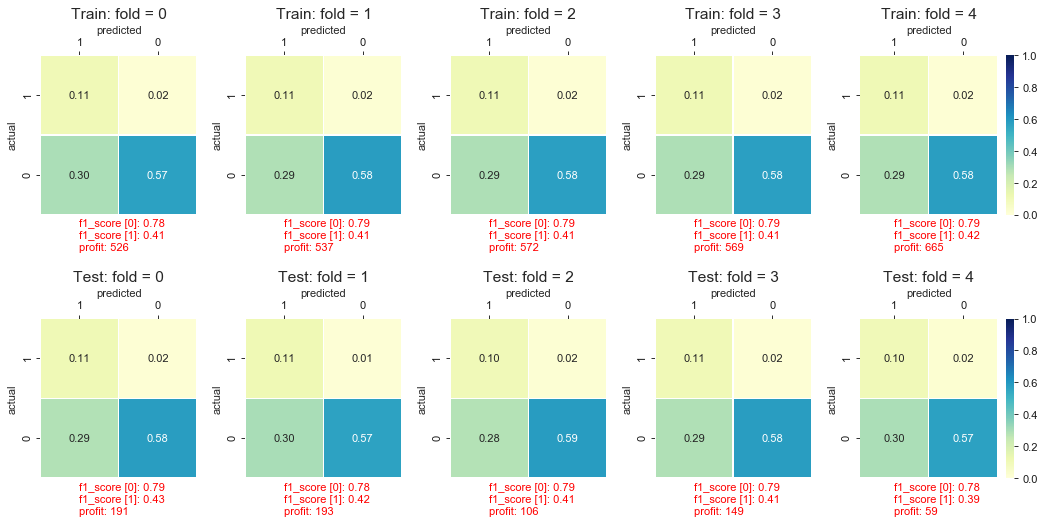

In [52]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNBs_CM, f1_score_train_NBs, f1_score_test_NBs, profit_train_NBs, profit_test_NBs = \
f_CM_heatmap('NB', n_cv, nvars, theoretical_threshold, True)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NBs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NBs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NBs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NBs[1])
model_cmp_total_profit_train.append(sum(profit_train_NBs))
model_cmp_total_profit_test.append(sum(profit_test_NBs))

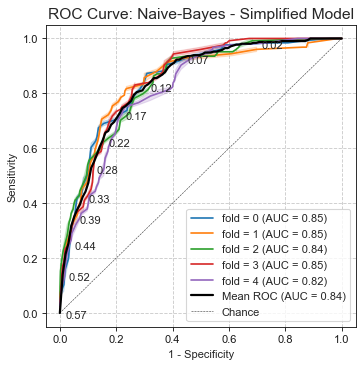

In [53]:
# plot the ROC Curve
figmodelNBs_ROC, NBs_mean_auc = f_ROC_Curve('NB', n_cv, nvars, 'ROC Curve: Naive-Bayes - Simplified Model')
plt.show(figmodelNBs_ROC)
model_cmp_mean_auc.append(NBs_mean_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="simplified-model-neuralnet"></a>
#### 4.2.4: Neural Networks

In [54]:
model_cmp.append(nvars)
model_cmp_type.append('NeuralNetwork')

<b>Test the learning rate ...</b>

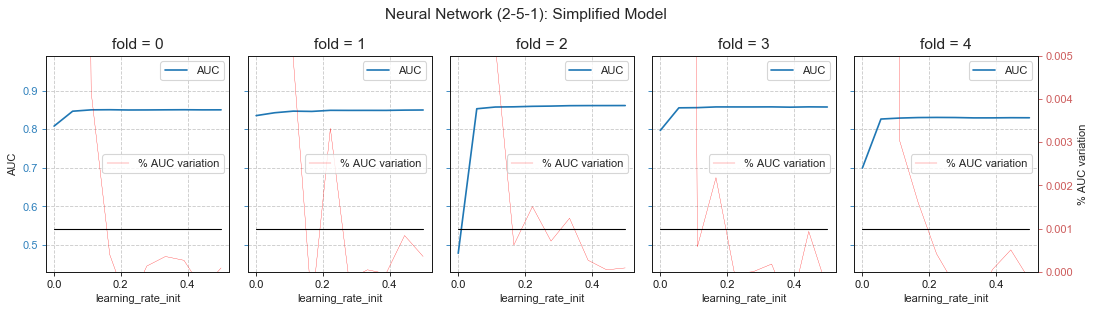

In [55]:
# test Learning Rate
figmodelNTs_LR = f_model_NT_testLR(0.001, 0.5, 5, 'Neural Network (2-5-1): Simplified Model')
plt.show(figmodelNTs_LR)

Looking at these plots let's choose learning_rate_init = 0.1.

In [56]:
learning_rate_init = .1

<b>Test the network architecture ...</b>

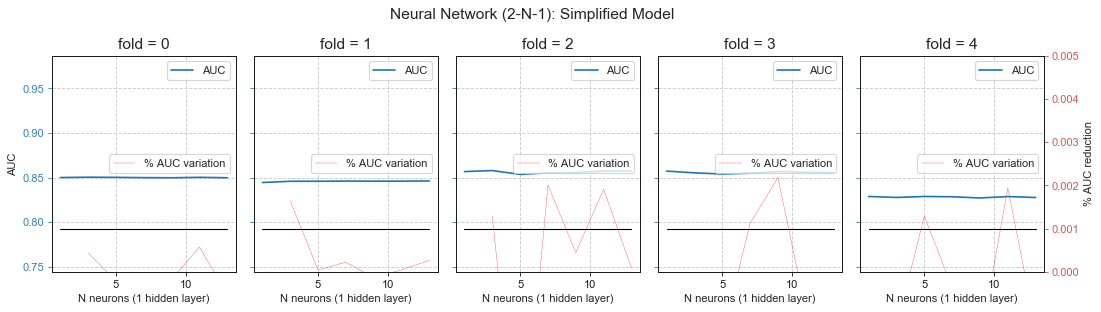

In [57]:
# test Network Architecture
figmodelNTs_N = f_model_NT_testNeurons(learning_rate_init, 1, 15, 2, 'Neural Network (2-N-1): Simplified Model')
plt.show(figmodelNTs_N)

Looking at these plots let's choose 5 for the number of neurons on a single hidden layer.

In [58]:
n_neurons = 5

In [59]:
# build the models
for cv in range(n_cv):
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 200,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = learning_rate_init,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = (n_neurons),\
         n_iter_no_change = 3, tol = 5e-4)')
    
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

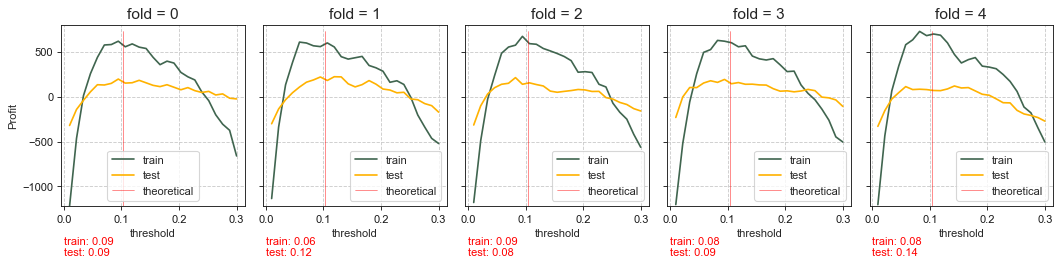

In [60]:
# plot the profit vs threshold
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold_profit('NN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNNs_thresholds)

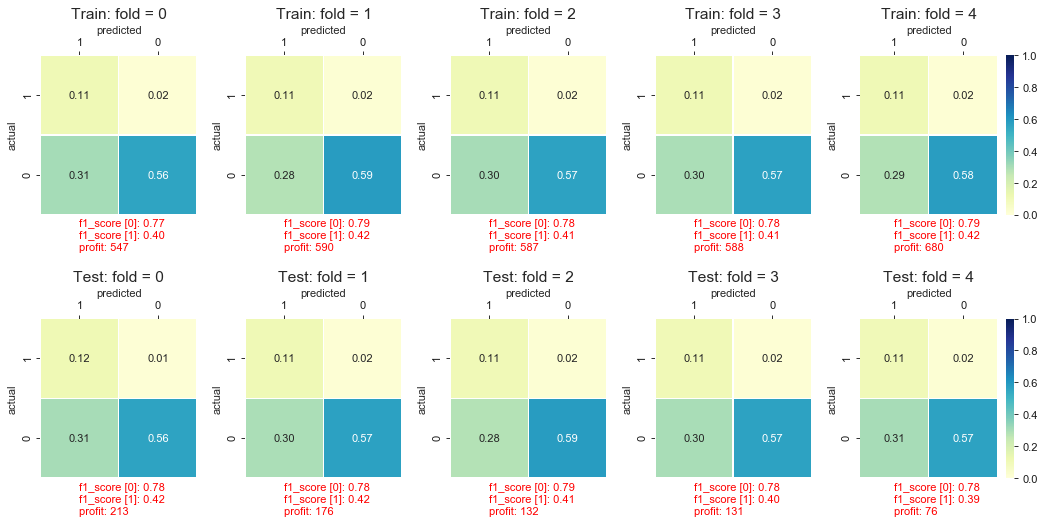

In [61]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNNs_CM, f1_score_train_NNs, f1_score_test_NNs, profit_train_NNs, profit_test_NNs = \
f_CM_heatmap('NN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NNs[1])
model_cmp_total_profit_train.append(sum(profit_train_NNs))
model_cmp_total_profit_test.append(sum(profit_test_NNs))

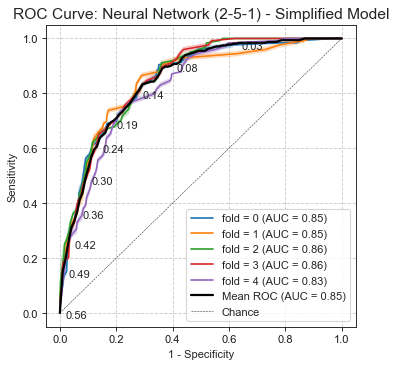

In [62]:
# plot the ROC Curve
figmodelNNs_ROC, NNs_mean_auc = f_ROC_Curve('NN', n_cv, nvars, 'ROC Curve: Neural Network (2-5-1) - Simplified Model')
plt.show(figmodelNNs_ROC)
model_cmp_mean_auc.append(NNs_mean_auc)

<a class="anchor" id="simplified-ki"></a>
<b>Key Insights</b>:
   > <p><b>Model Stability</b>: We can observe that all the models built are stable (the f1-score for both classes is stable across the different folds for train and test data).</p> 
   > <p><b>Theoretical Threshold & Profit</b>: As expected the adjusted profit varies with the cutoff value but the maximum profit value was observed around the theoretical threshold derived from the cost matrix for all the models tested. In all of the simplified models the adjusted profit is already positive for all the cross folds both in training and test data, which means that if any of these models were to be used on the previous campaigns we could improve the results essentially by avoiding the relevant number of true negatives with a cost of 3€/customer. In this case the models perform in a very similar fashion.</p>
     > <p><b>ROC Curve</b>: Despite some fluctuations visible on the ROC curves for the different cross folds in every model, we could obtain models with an area under the curve with a value already higher than 0.8.</p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="intermediate-model"></a>
### 4.3: Intermediate Model

<b>Input Variables (Group 1 + 2)</b>: `Recency_z`, `MntAdventure_z`, `NumCatalogPurchases_z`, `Income_z`, `NumWebVisitsMonth_z`

In [63]:
list_vars = ['Recency_z', 'MntAdventure_z', 'NumCatalogPurchases_z', 'Income_z', 'NumWebVisitsMonth_z']
nvars = len(list_vars)

<a class="anchor" id="intermediate-model-sampling"></a>
#### 4.3.1: Sampling (Stratified k-Fold Cross-Validation)

In [64]:
target = df_predictive['DepVar'].values
data = df_predictive[list_vars].values

skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(target, data)

cv = 0
for train_index, test_index in skf.split(data, target):
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    cv = cv + 1

n_cv = cv

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="intermediate-model-kmeans"></a>
#### 4.3.2: K-Nearest Neighbours

In [65]:
model_cmp.append(nvars)
model_cmp_type.append('KNN')

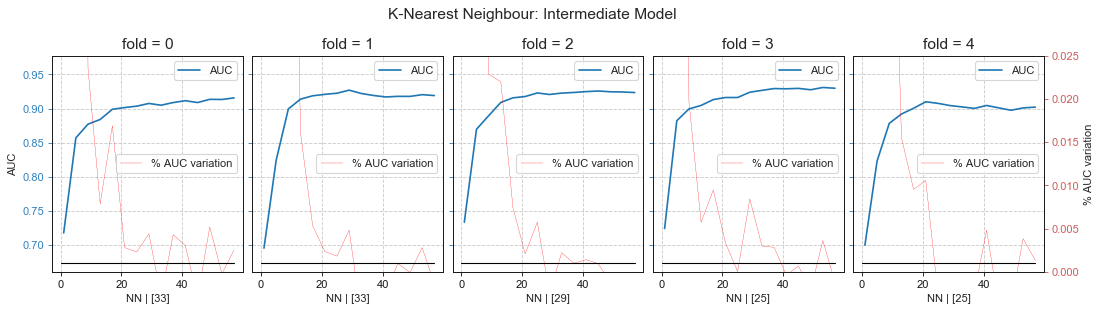

In [66]:
# test k NN (number of Nearest Neighbours)
figmodelKNNs = f_model_KNN_test(60, 4, 'K-Nearest Neighbour: Intermediate Model')
plt.show(figmodelKNNs)

Looking at these plots let's choose K = 35.

In [67]:
k = 35

In [68]:
# build the models (only for the best NN)
for cv in range(n_cv): 
    exec('modelKNN_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('modelKNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

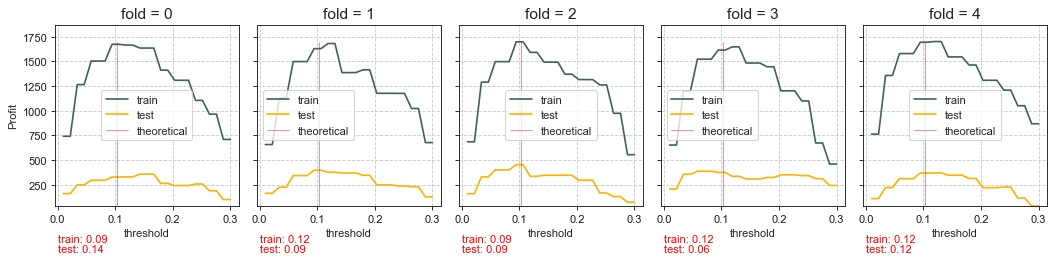

In [69]:
# plot the profit vs threshold
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold_profit('KNN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelKNNs_thresholds)

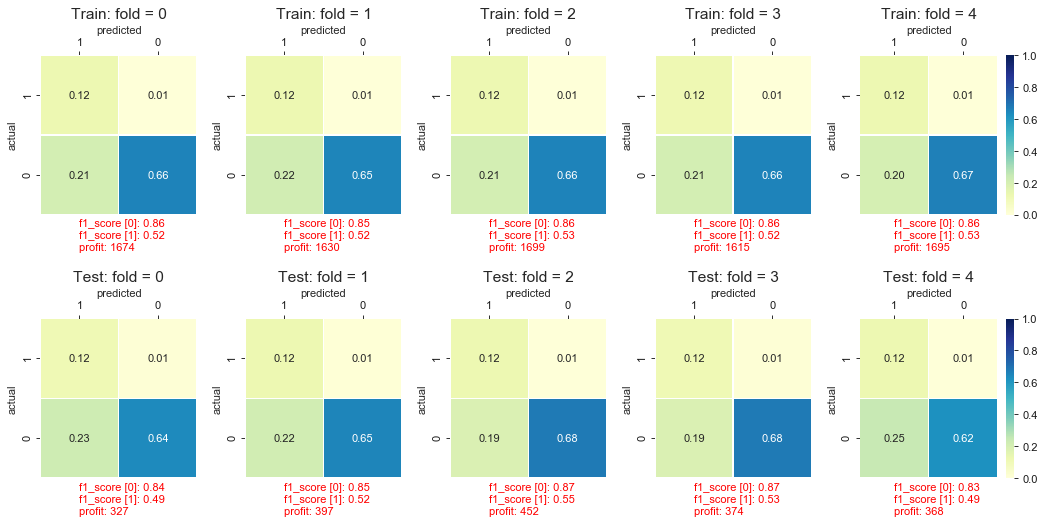

In [70]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelKNNs_CM, f1_score_train_KNNs, f1_score_test_KNNs, profit_train_KNNs, profit_test_KNNs = \
f_CM_heatmap('KNN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_KNNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_KNNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_KNNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_KNNs[1])
model_cmp_total_profit_train.append(sum(profit_train_KNNs))
model_cmp_total_profit_test.append(sum(profit_test_KNNs))

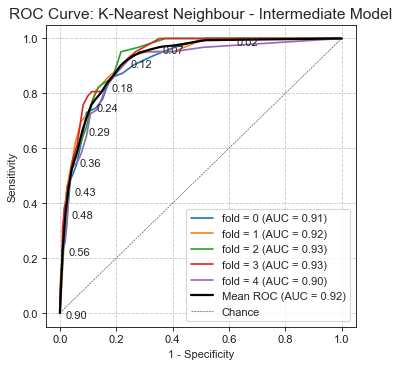

In [71]:
# plot the ROC Curve
figmodelKNNs_ROC, KNNs_mean_auc = f_ROC_Curve('KNN', n_cv, nvars, 'ROC Curve: K-Nearest Neighbour - Intermediate Model')
plt.show(figmodelKNNs_ROC)
model_cmp_mean_auc.append(KNNs_mean_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="intermediate-model-naivebayes"></a>
#### 4.3.3: Naive Bayes

In [72]:
model_cmp.append(nvars)
model_cmp_type.append('NaiveBayes')

In [73]:
# build the models
for cv in range(n_cv): 
    exec('modelNB_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('modelNB_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

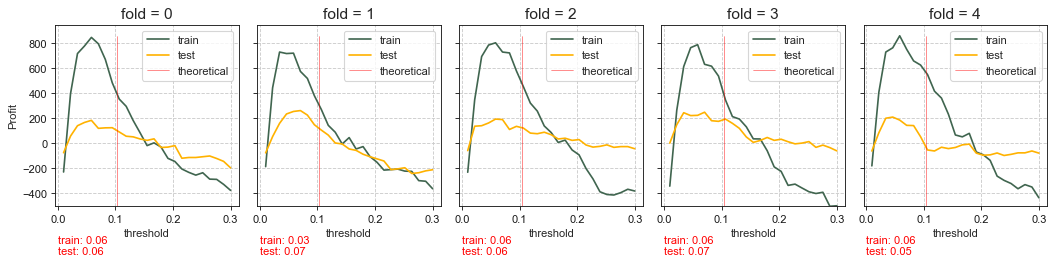

In [74]:
# plot the profit vs threshold
figmodelNBs_thresholds, NBs_best_threshold_train, NBs_best_threshold_test = \
f_threshold_profit('NB', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNBs_thresholds)

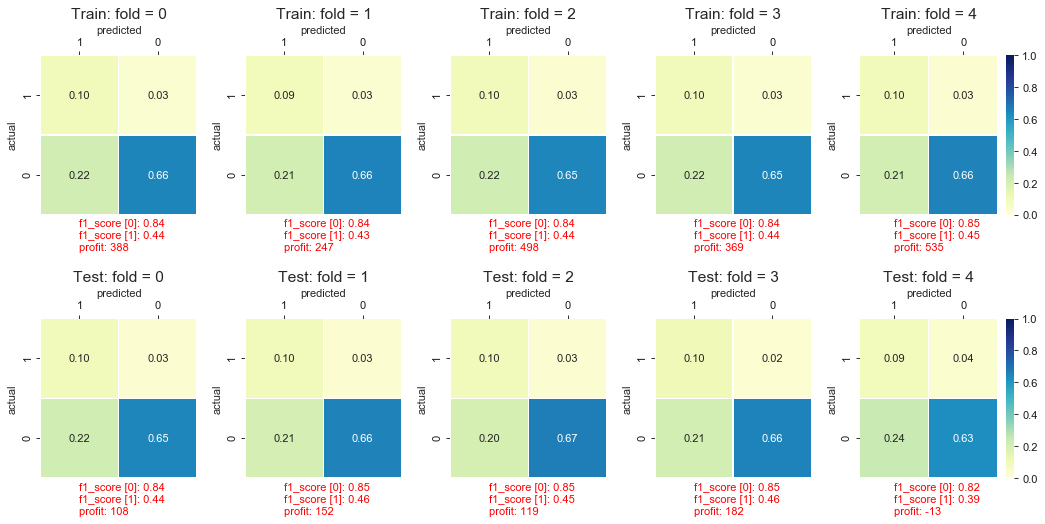

In [75]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNBs_CM, f1_score_train_NBs, f1_score_test_NBs, profit_train_NBs, profit_test_NBs = \
f_CM_heatmap('NB', n_cv, nvars, theoretical_threshold, True)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NBs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NBs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NBs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NBs[1])
model_cmp_total_profit_train.append(sum(profit_train_NBs))
model_cmp_total_profit_test.append(sum(profit_test_NBs))

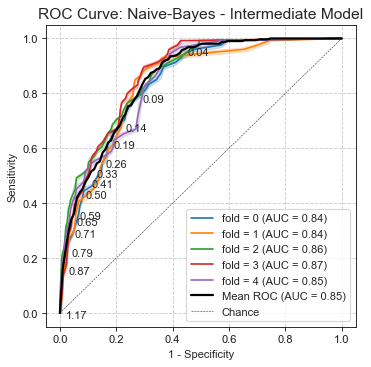

In [76]:
# plot the ROC Curve
figmodelNBs_ROC, NBs_mean_auc = f_ROC_Curve('NB', n_cv, nvars, 'ROC Curve: Naive-Bayes - Intermediate Model')
plt.show(figmodelNBs_ROC)
model_cmp_mean_auc.append(NBs_mean_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="intermediate-model-neuralnet"></a>
#### 4.3.4: Neural Networks

In [77]:
model_cmp.append(nvars)
model_cmp_type.append('NeuralNetwork')

<b>Test the learning rate ...</b>

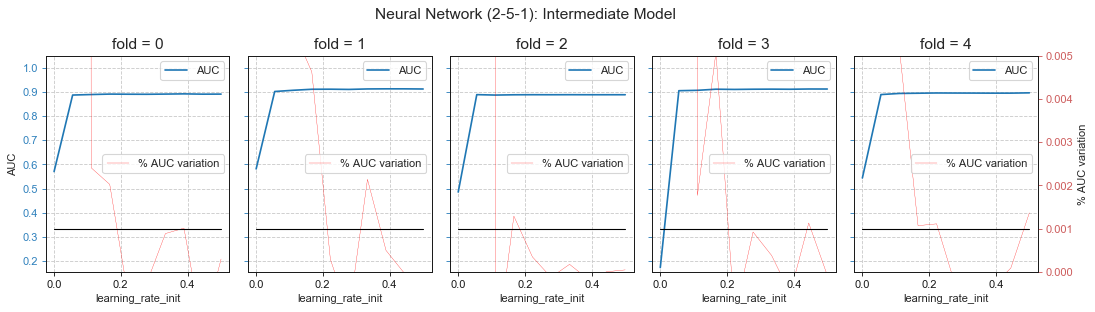

In [78]:
# test Learning Rate
figmodelNTs_LR = f_model_NT_testLR(0.001, 0.5, 5, 'Neural Network (2-5-1): Intermediate Model')
plt.show(figmodelNTs_LR)

Looking at these plots let's choose learning_rate_init = 0.2.

In [79]:
learning_rate_init = .2

<b>Test the network architecture ...</b>

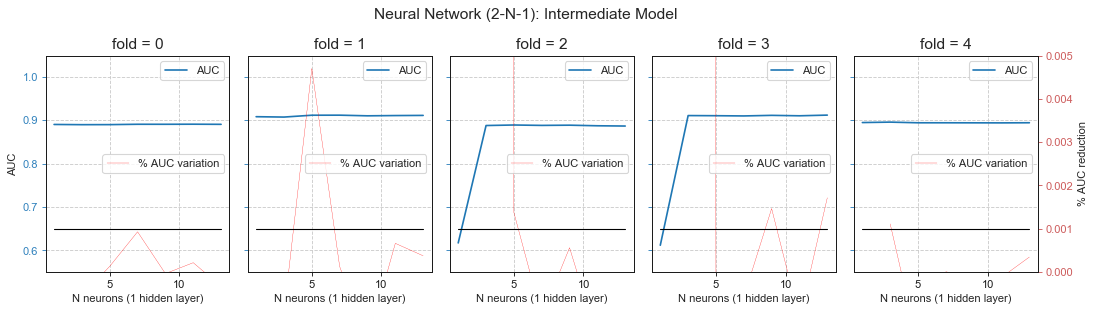

In [80]:
# test Network Architecture
figmodelNTs_N = f_model_NT_testNeurons(learning_rate_init, 1, 15, 2, 'Neural Network (2-N-1): Intermediate Model')
plt.show(figmodelNTs_N)

Looking at these plots let's choose 5 for the number of neurons on a single hidden layer.

In [81]:
n_neurons = 5

In [82]:
# build the models
for cv in range(n_cv):
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 200,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = learning_rate_init,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = (n_neurons),\
         n_iter_no_change = 3, tol = 5e-4)')
    
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

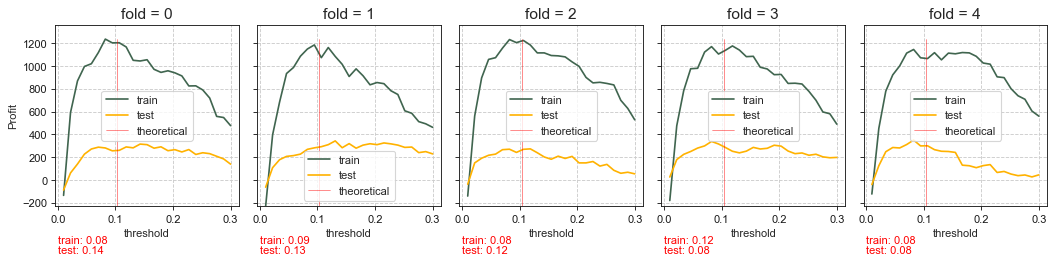

In [83]:
# plot the profit vs threshold
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold_profit('NN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNNs_thresholds)

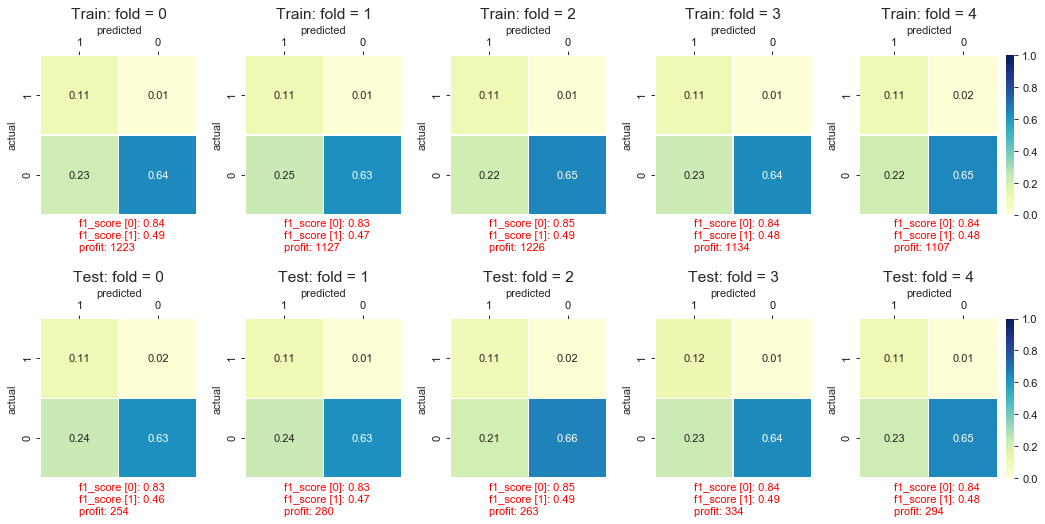

In [84]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNNs_CM, f1_score_train_NNs, f1_score_test_NNs, profit_train_NNs, profit_test_NNs = \
f_CM_heatmap('NN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NNs[1])
model_cmp_total_profit_train.append(sum(profit_train_NNs))
model_cmp_total_profit_test.append(sum(profit_test_NNs))

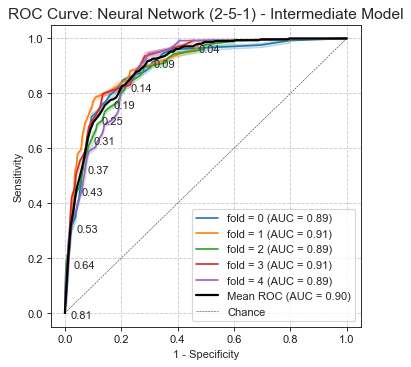

In [85]:
# plot the ROC Curve
figmodelNNs_ROC, NNs_mean_auc = f_ROC_Curve('NN', n_cv, nvars, 'ROC Curve: Neural Network (2-5-1) - Intermediate Model')
plt.show(figmodelNNs_ROC)
model_cmp_mean_auc.append(NNs_mean_auc)

<a class="anchor" id="intermediate-ki"></a>
<b>Key Insights</b>:
<b>Key Insights</b>:
   > <p><b>Model Stability</b>: Again, we can observe that all the models built are stable (the f1-score for both classes is stable across the different folds for train and test data).</p>
   > <p><b>Theoretical Threshold & Profit</b>: In the Naïve-Bayes we can observe that the maximum adjusted profit value is starting to shift from the theoretical threshold with a decrease on the adjusted profit on both the test and train data from the Simplified Models. KNN and NeuralNetwork models exhibit an improvement in the adjusted profit value compared to the Simplified Models essentially by converting the false positives and negatives into true positives and negatives. In this case the KNN outperforms the other models.</p>
   > <p><b>ROC Curve</b>: Despite some fluctuations visible on the ROC curves for the different cross folds in every model, we could obtain models with an area under the curve with a value already higher than 0.9, specially for the KNN models.</p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="inclusive-model"></a>
### 4.4: More Inclusive Model

<b>Input Variables (Group 1 + 2 +3)</b>: `Recency_z`, `MntAdventure_z`, `NumCatalogPurchases_z`, `Income_z`, `NumWebVisitsMonth_z`, `NumDealsPurchases_z`, `MntTechnical_z`, `MntHardcover_z`, `MntTravelling_z`, `NumStorePurchases_z`, `TotalPurchases_z`, `MntRomance_z`, `Age_z`, `MntHistory_z`

In [86]:
list_vars = ['Recency_z', 'MntAdventure_z', 'NumCatalogPurchases_z', 'Income_z', 'NumWebVisitsMonth_z',\
             'NumDealsPurchases_z', 'MntTechnical_z', 'MntHardcover_z', 'MntTravelling_z', 'NumStorePurchases_z',\
             'TotalPurchases_z', 'MntRomance_z', 'Age_z', 'MntHistory_z']
nvars = len(list_vars)

<a class="anchor" id="inclusive-model-sampling"></a>
#### 4.4.1: Sampling (Stratified k-Fold Cross-Validation)

In [87]:
target = df_predictive['DepVar'].values
data = df_predictive[list_vars].values

skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(target, data)

cv = 0
for train_index, test_index in skf.split(data, target):
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    cv = cv + 1

n_cv = cv

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="inclusive-model-kmeans"></a>
#### 4.4.2: K-Nearest Neighbours

In [88]:
model_cmp.append(nvars)
model_cmp_type.append('KNN')

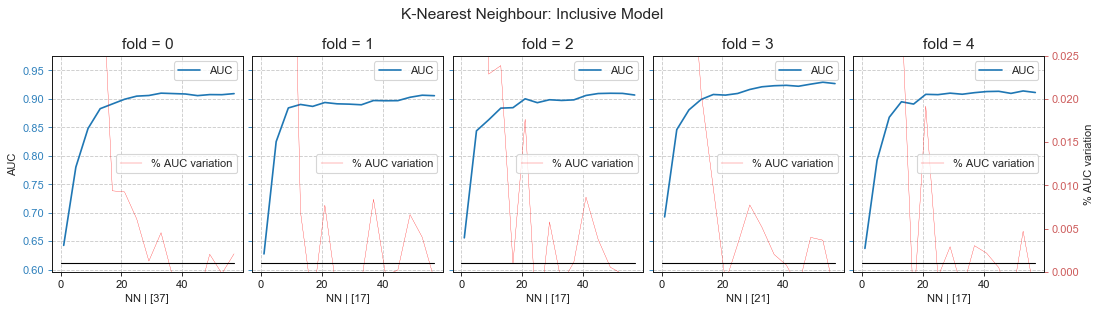

In [89]:
# test k NN (number of Nearest Neighbours)
figmodelKNNs = f_model_KNN_test(60, 4, 'K-Nearest Neighbour: Inclusive Model')
plt.show(figmodelKNNs)

Looking at these plots let's choose K = 45.

In [90]:
k = 45

In [91]:
# build the models (only for the best NN)
for cv in range(n_cv): 
    exec('modelKNN_' + str(cv) + '_' + str(nvars) + ' = KNeighborsClassifier(n_neighbors = k)')
    exec('modelKNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

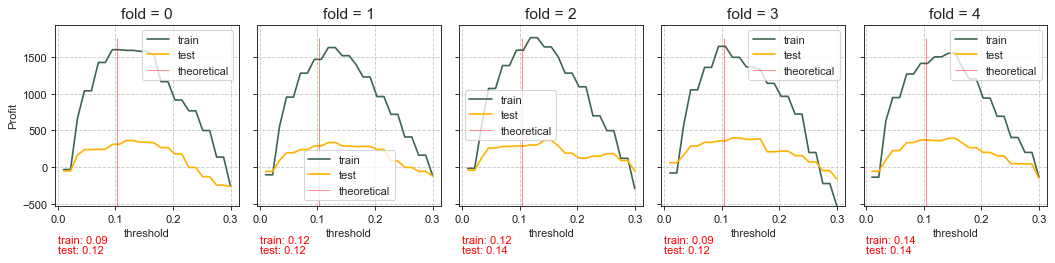

In [92]:
# plot the profit vs threshold
figmodelKNNs_thresholds, KNNs_best_threshold_train, KNNs_best_threshold_test = \
f_threshold_profit('KNN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelKNNs_thresholds)

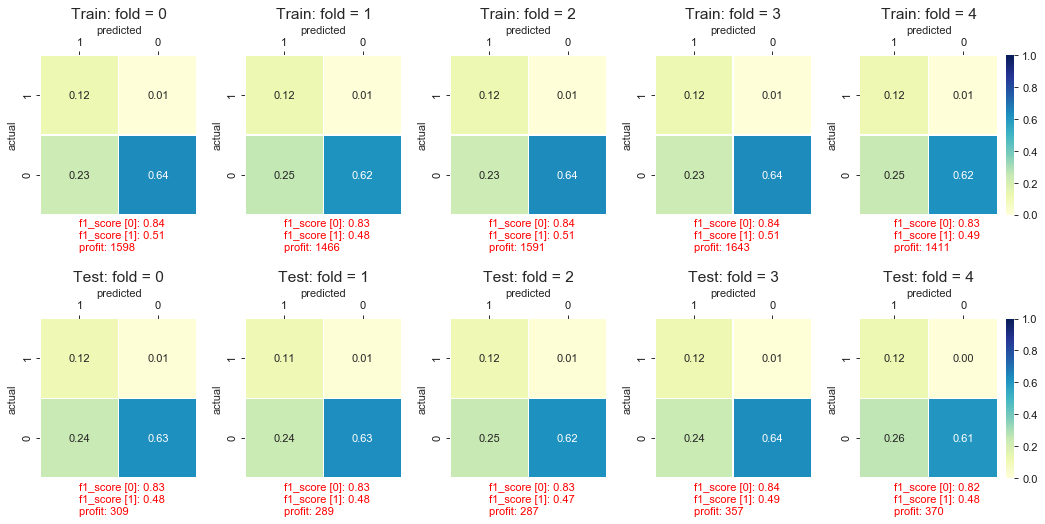

In [93]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelKNNs_CM, f1_score_train_KNNs, f1_score_test_KNNs, profit_train_KNNs, profit_test_KNNs = \
f_CM_heatmap('KNN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelKNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_KNNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_KNNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_KNNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_KNNs[1])
model_cmp_total_profit_train.append(sum(profit_train_KNNs))
model_cmp_total_profit_test.append(sum(profit_test_KNNs))

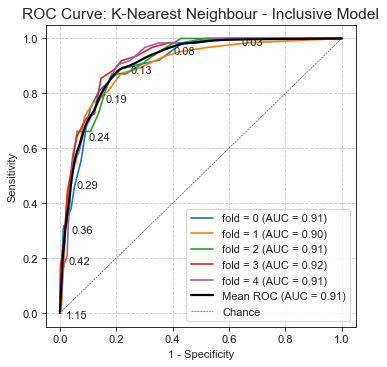

In [94]:
# plot the ROC Curve
figmodelKNNs_ROC, KNNs_mean_auc = f_ROC_Curve('KNN', n_cv, nvars, 'ROC Curve: K-Nearest Neighbour - Inclusive Model')
plt.show(figmodelKNNs_ROC)
model_cmp_mean_auc.append(KNNs_mean_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="inclusive-model-naivebayes"></a>
#### 4.4.3: Naive Bayes

In [95]:
model_cmp.append(nvars)
model_cmp_type.append('NaiveBayes')

In [96]:
# build the models
for cv in range(n_cv): 
    exec('modelNB_' + str(cv) + '_' + str(nvars) + ' = GaussianNB()')
    exec('modelNB_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

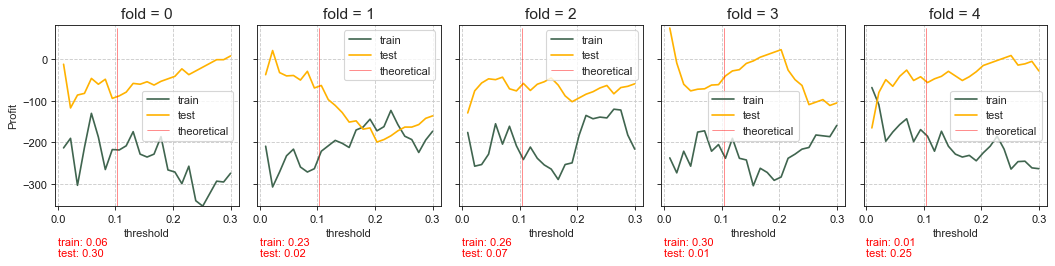

In [97]:
# plot the profit vs threshold
figmodelNBs_thresholds, NBs_best_threshold_train, NBs_best_threshold_test = \
f_threshold_profit('NB', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNBs_thresholds)

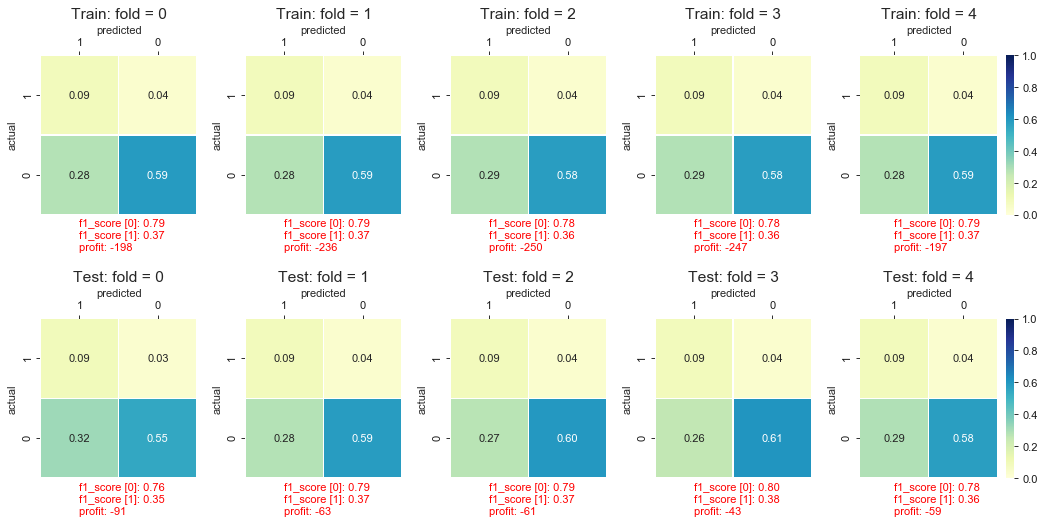

In [98]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNBs_CM, f1_score_train_NBs, f1_score_test_NBs, profit_train_NBs, profit_test_NBs = \
f_CM_heatmap('NB', n_cv, nvars, theoretical_threshold, True)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NBs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NBs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NBs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NBs[1])
model_cmp_total_profit_train.append(sum(profit_train_NBs))
model_cmp_total_profit_test.append(sum(profit_test_NBs))

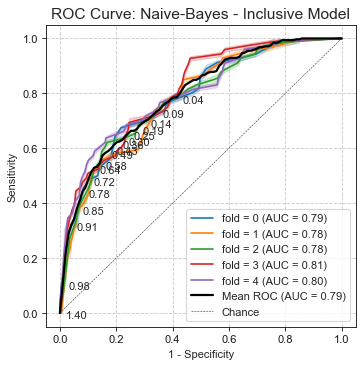

In [99]:
# plot the ROC Curve
figmodelNBs_ROC, NBs_mean_auc = f_ROC_Curve('NB', n_cv, nvars, 'ROC Curve: Naive-Bayes - Inclusive Model')
plt.show(figmodelNBs_ROC)
model_cmp_mean_auc.append(NBs_mean_auc)

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="inclusive-model-neuralnet"></a>
#### 4.4.4: Neural Networks

In [100]:
model_cmp.append(nvars)
model_cmp_type.append('NeuralNetwork')

<b>Test the learning rate ...</b>

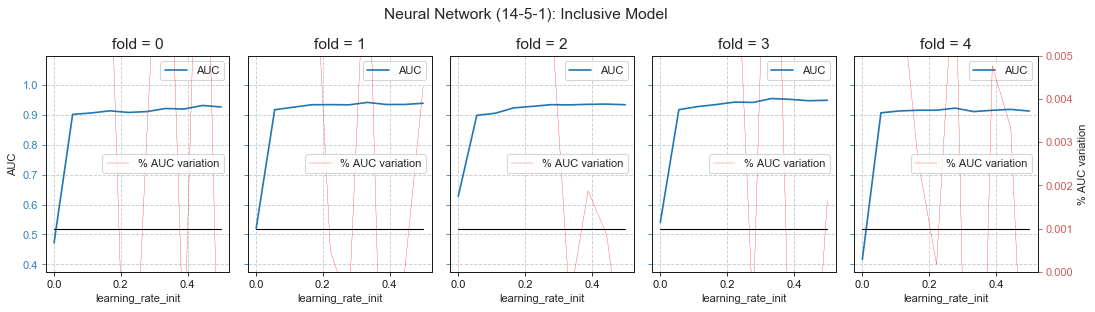

In [101]:
# test Learning Rate
figmodelNTs_LR = f_model_NT_testLR(0.001, 0.5, 5, 'Neural Network (14-5-1): Inclusive Model')
plt.show(figmodelNTs_LR)

Looking at these plots let's choose learning_rate_init = 0.3.

In [102]:
learning_rate_init = .3

<b>Test the network architecture ...</b>

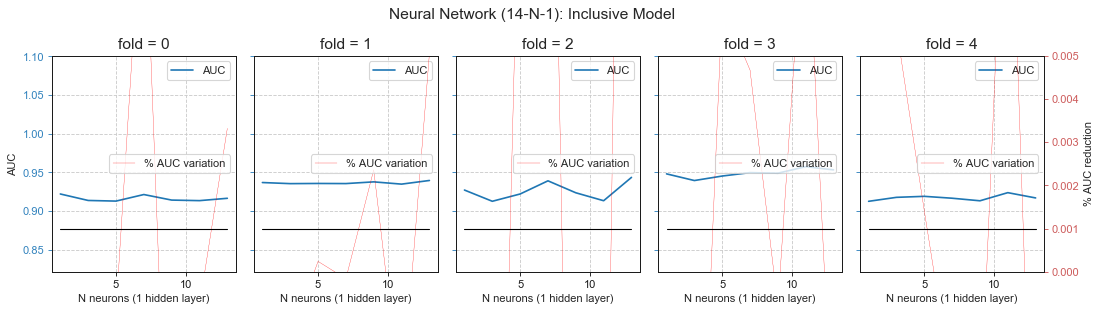

In [103]:
# test Network Architecture
figmodelNTs_N = f_model_NT_testNeurons(learning_rate_init, 1, 15, 2, 'Neural Network (14-N-1): Inclusive Model')
plt.show(figmodelNTs_N)

Looking at these plots let's choose 5 for the number of neurons on a single hidden layer.

In [104]:
n_neurons = 5

In [105]:
# build the models
for cv in range(n_cv):
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 200,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = learning_rate_init,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = (n_neurons),\
         n_iter_no_change = 3, tol = 5e-4)')
    
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

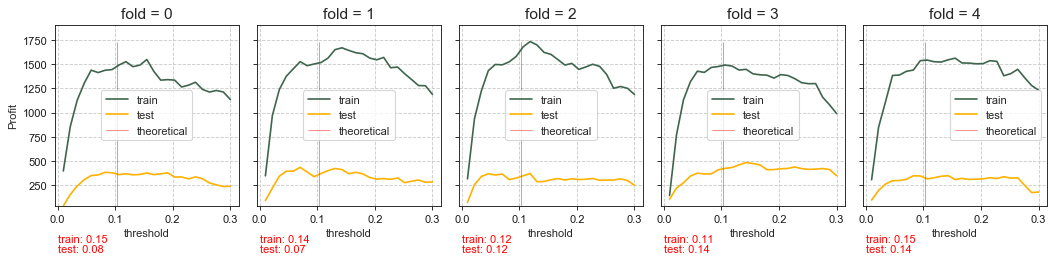

In [106]:
# plot the profit vs threshold
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold_profit('NN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNNs_thresholds)

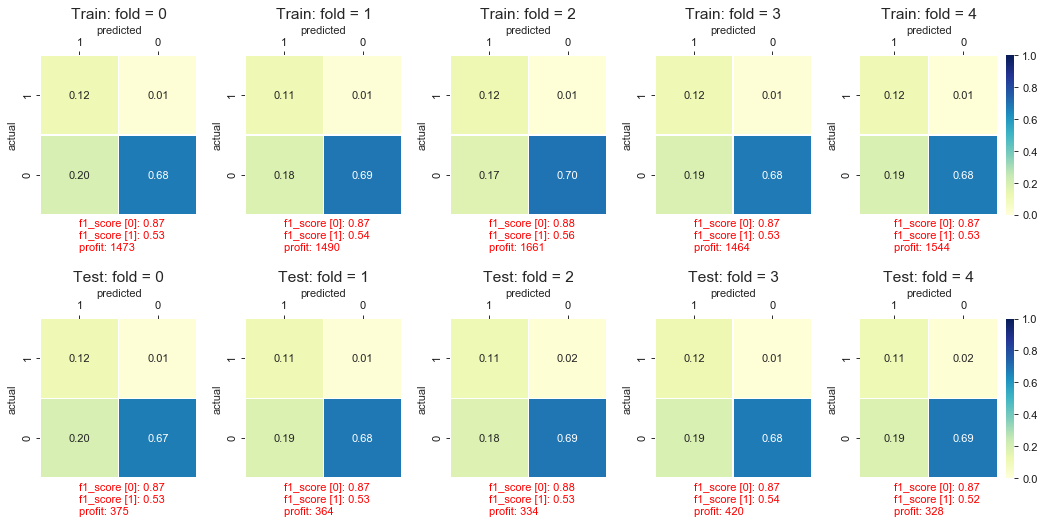

In [107]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNNs_CM, f1_score_train_NNs, f1_score_test_NNs, profit_train_NNs, profit_test_NNs = \
f_CM_heatmap('NN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NNs[1])
model_cmp_total_profit_train.append(sum(profit_train_NNs))
model_cmp_total_profit_test.append(sum(profit_test_NNs))

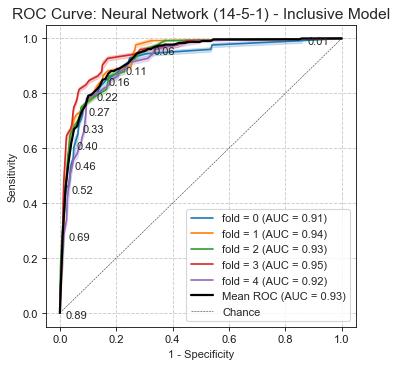

In [108]:
# plot the ROC Curve
figmodelNNs_ROC, NNs_mean_auc = f_ROC_Curve('NN', n_cv, nvars, 'ROC Curve: Neural Network (14-5-1) - Inclusive Model')
plt.show(figmodelNNs_ROC)
model_cmp_mean_auc.append(NNs_mean_auc)

<a class="anchor" id="inclusive-ki"></a>
<b>Key Insights</b>:
   > <p><b>Model Stability</b>: We can observe that all the models built are stable (the f1-score for both classes is stable across the different folds for train and test data). On the Neural Network models, it is now required to increase the learning rate and the number of neurons on a single hidden layer architecture to have stable and better results.</p>
   > <p><b>Theoretical Threshold & Profit</b>: For the Naïve-Bayes it is possible to observe an erratic behavior on the adjusted profit relation with the cutoff value and now it is negative for all More Inclusive Models built. So, despite being stable the Naïve-Bayes clearly shows that there is no point in bringing in more variables for this type of models. On the KNN it is possible to observe that the More Inclusive Models start to lose accuracy and we have now worse adjusted profit predictions when compared to the Intermediate Model, so there is also no point in bringing in more variables for this type of models. However, for the Neural Networks it is possible to observe an improvement from the Intermediate Models in terms of accuracy and adjusted profit predictions that is still well behaved for the theoretical threshold, but nevertheless not significative higher than the best KNN models from the Intermediate Models. </p>
   > <p><b>ROC Curve</b>: The area under the ROC curve drops for the KNN and Naïve-Bayes models, but it increases for the Neural Network models.</p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="full-model"></a>
### 4.5: Full Model

<b>Input Variables (Group 1 + 2 + 3 + 4)</b>: `Recency_z`, `MntAdventure_z`, `NumCatalogPurchases_z`, `Income_z`, `NumWebVisitsMonth_z`, `NumDealsPurchases_z`, `MntTechnical_z`, `MntHardcover_z`, `MntTravelling_z`, `TotalPurchases_z`, `MntRomance_z`, `Age_z`, `MntHistory_z`, `NumWebPurchases_z`, `MStatus_Together_flag`, `MStatus_Single_flag`, `Kidhome_0_flag`, `Kidhome_1_flag`, `MntTravelling_flag`, `MStatus_Divorced_flag`, `Education_Graduation_flag`, `MStatus_Widow_flag`, `MntRomance_flag`

In [109]:
list_vars = ['Recency_z', 'MntAdventure_z', 'NumCatalogPurchases_z', 'Income_z', 'NumWebVisitsMonth_z',\
             'NumDealsPurchases_z', 'MntTechnical_z', 'MntHardcover_z', 'MntTravelling_z', 'NumStorePurchases_z',\
             'MntRomance_z', 'Age_z', 'MntHistory_z',\
             'NumWebPurchases_z', 'MStatus_Together_flag', 'MStatus_Single_flag', 'Kidhome_0_flag', 'Kidhome_1_flag',\
             'MntTravelling_flag', 'MStatus_Divorced_flag', 'Education_Graduation_flag', 'MStatus_Widow_flag',\
             'MntRomance_flag']
nvars = len(list_vars)

<a class="anchor" id="full-model-sampling"></a>
#### 4.5.1: Sampling (Stratified k-Fold Cross-Validation)

In [110]:
target = df_predictive['DepVar'].values
data = df_predictive[list_vars].values

skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(target, data)

cv = 0
for train_index, test_index in skf.split(data, target):
    exec('X_train_' + str(cv) + ', ' + 'X_test_' + str(cv) + ' = data[train_index], data[test_index]')
    exec('y_train_' + str(cv) + ', ' + 'y_test_' + str(cv) + ' = target[train_index], target[test_index]')
    cv = cv + 1

n_cv = cv

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="full-model-neuralnet"></a>
#### 4.5.2: Neural Networks

In [111]:
model_cmp.append(23)
model_cmp_type.append('NeuralNetwork')

<b>Test the learning rate ...</b>

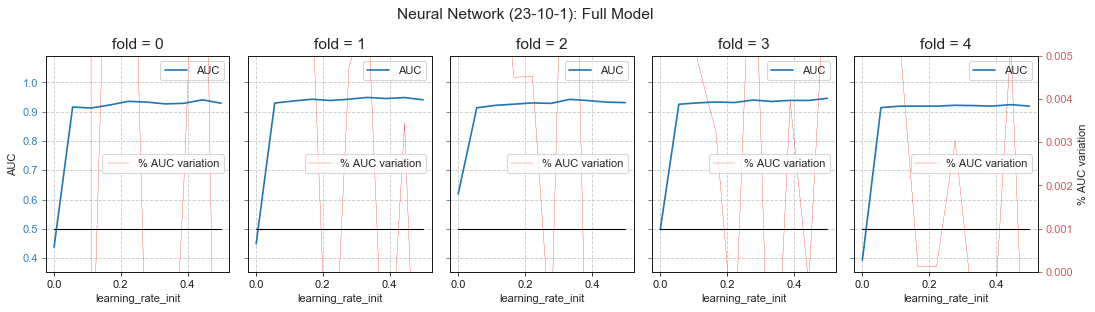

In [112]:
# test Learning Rate
figmodelNTs_LR = f_model_NT_testLR(0.001, 0.5, 10, 'Neural Network (23-10-1): Full Model')
plt.show(figmodelNTs_LR)

Looking at these plots let's choose learning_rate_init = 0.4.

In [113]:
learning_rate_init = .4

<b>Test the network architecture ...</b>

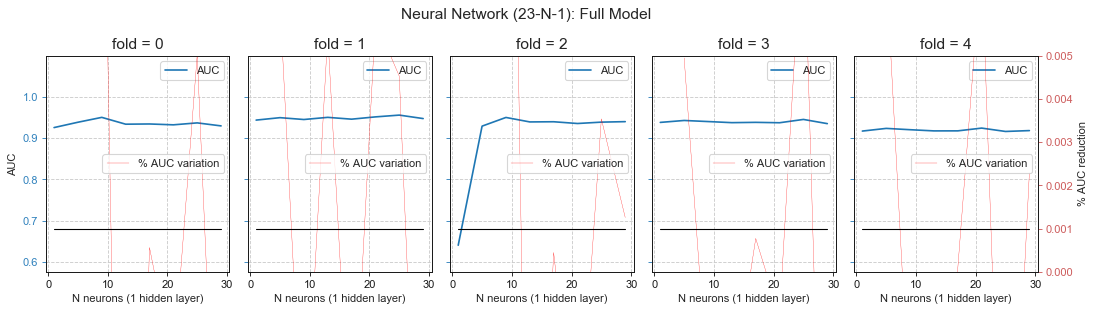

In [114]:
# test Network Architecture
figmodelNTs_N = f_model_NT_testNeurons(learning_rate_init, 1, 31, 4, 'Neural Network (23-N-1): Full Model')
plt.show(figmodelNTs_N)

Looking at these plots let's choose 10 for the number of neurons on a single hidden layer.

In [115]:
n_neurons = 10

In [116]:
# build the models
for cv in range(n_cv):
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '= MLPClassifier(solver = ' + '\'' + 'sgd' + '\'' +\
         ', activation = ' + '\'' + 'logistic' + '\'' + ', max_iter = 200,' +\
         'learning_rate = ' + '\'' + 'adaptive' + '\'' + ', learning_rate_init = learning_rate_init,\
         random_state = None, shuffle = True, momentum = .9,\
         hidden_layer_sizes = (n_neurons),\
         n_iter_no_change = 3, tol = 5e-4)')
    
    exec('modelNN_' + str(cv) + '_' + str(nvars) + '.fit(' + 'X_train_' + str(cv) + ', ' + 'y_train_' + str(cv) + ')')

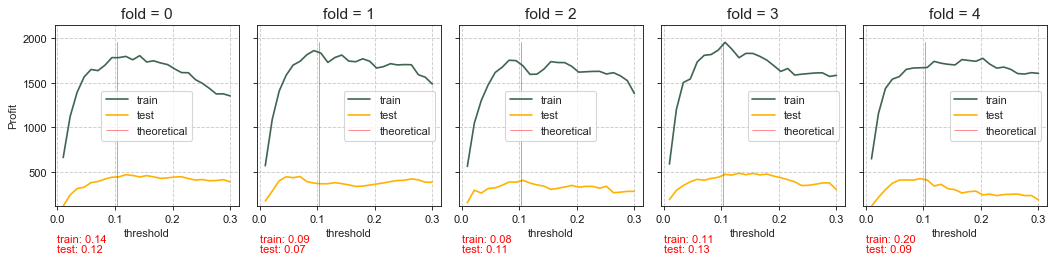

In [117]:
# plot the profit vs threshold
figmodelNNs_thresholds, NNs_best_threshold_train, NNs_best_threshold_test = \
f_threshold_profit('NN', n_cv, nvars, theoretical_threshold)
plt.show(figmodelNNs_thresholds)

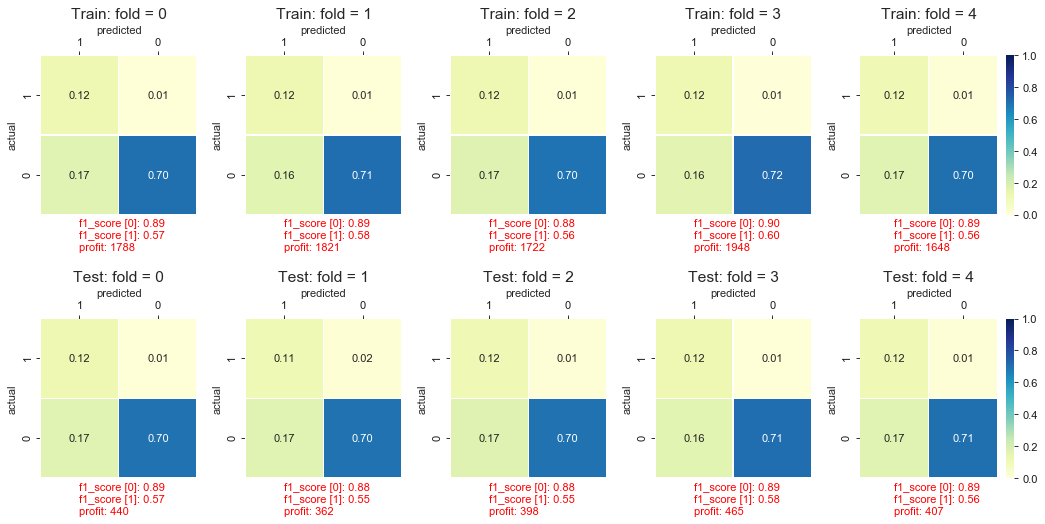

In [118]:
# plot the Confusion Matrix (CM): adjusted with the theoretical threshold
figmodelNNs_CM, f1_score_train_NNs, f1_score_test_NNs, profit_train_NNs, profit_test_NNs = \
f_CM_heatmap('NN', n_cv, nvars, theoretical_threshold, True)
plt.show(figmodelNNs_CM)
model_cmp_mean_f1_score_train_0.append(f1_score_train_NNs[0])
model_cmp_mean_f1_score_train_1.append(f1_score_train_NNs[1])
model_cmp_mean_f1_score_test_0.append(f1_score_test_NNs[0])
model_cmp_mean_f1_score_test_1.append(f1_score_test_NNs[1])
model_cmp_total_profit_train.append(sum(profit_train_NNs))
model_cmp_total_profit_test.append(sum(profit_test_NNs))

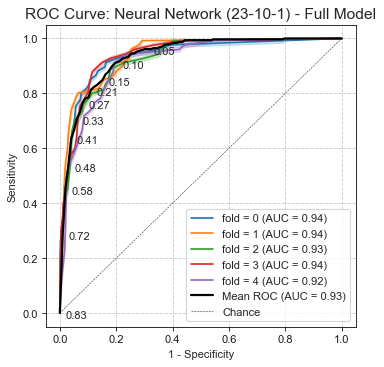

In [119]:
# plot the ROC Curve
figmodelNNs_ROC, NNs_mean_auc = f_ROC_Curve('NN', n_cv, nvars, 'ROC Curve: Neural Network (23-10-1) - Full Model')
plt.show(figmodelNNs_ROC)
model_cmp_mean_auc.append(NNs_mean_auc)

<a class="anchor" id="full-ki"></a>
<b>Key Insights</b>:
   > <p><b>Model Stability</b>: We can observe that all the models built are stable (the f1-score for both classes is stable across the different folds for train and test data). It is now required to increase again the learning rate but without changing the number of neurons on a single hidden layer architecture to have stable and better results.</p> 
   > <p><b>Theoretical Threshold & Profit</b>: It is possible to observe an improvement from the More Inclusive Models in terms of accuracy and adjusted profit predictions that is still well behaved for the theoretical threshold and now higher than the best KNN models from the Intermediate Models. </p>
     > <p><b>ROC Curve</b>: The area under the ROC curve still increases but much less than before.</p>

[Return to Table of Contents](#Table_Contents)

<a class="anchor" id="model-comparison"></a>
### 4.6: Model Comparison

To compare all the models we decided to plot the metrics evaluates for all models so it would be more clear which are the best ones.

In [120]:
df_model_cmp = pd.DataFrame(
    {'ModelVars': model_cmp,
     'ModelType': model_cmp_type,
     'mean_auc': model_cmp_mean_auc,
     'mean_f1_score_train_0': model_cmp_mean_f1_score_train_0,
     'mean_f1_score_train_1': model_cmp_mean_f1_score_train_1,
     'mean_f1_score_test_0': model_cmp_mean_f1_score_test_0,
     'mean_f1_score_test_1': model_cmp_mean_f1_score_test_1,
     'total_profit_train': model_cmp_total_profit_train,
     'total_profit_test': model_cmp_total_profit_test,
    })
df_model_cmp.T

,0,1,2,3,4,5,6,7,8,9
ModelVars,2,2,2,5,5,5,14,14,14,23
ModelType,KNN,NaiveBayes,NeuralNetwork,KNN,NaiveBayes,NeuralNetwork,KNN,NaiveBayes,NeuralNetwork,NeuralNetwork
mean_auc,0.835805,0.840684,0.846635,0.917106,0.850155,0.897521,0.909542,0.791198,0.928636,0.93356
mean_f1_score_train_0,0.808821,0.787022,0.784321,0.857476,0.841203,0.839113,0.83746,0.785573,0.872481,0.889611
mean_f1_score_train_1,0.445969,0.411696,0.411608,0.525961,0.439919,0.481214,0.499382,0.366162,0.537317,0.57518
mean_f1_score_test_0,0.802725,0.787542,0.782737,0.854204,0.840826,0.837889,0.82996,0.784132,0.870921,0.886179
mean_f1_score_test_1,0.422075,0.411075,0.409711,0.517175,0.441993,0.478963,0.479565,0.364362,0.53137,0.563215
total_profit_train,4804,2869,2992,8313,2037,5817,7709,-1128,7632,8927
total_profit_test,738,698,728,1918,548,1425,1612,-317,1821,2072


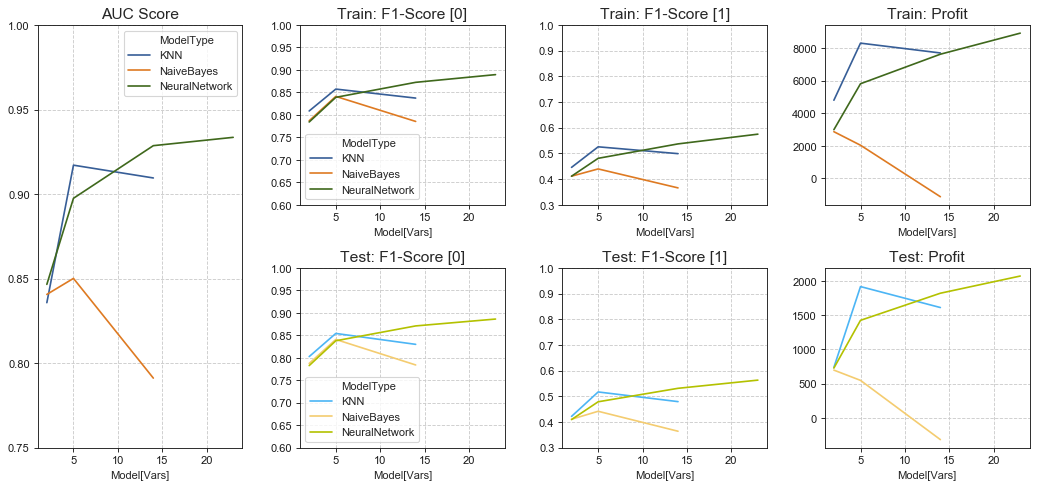

In [121]:
figmodel_cmp = f_model_cmp()
plt.show(figmodel_cmp)

From these plots two models stand out, the KNN with 5 vars (Intermediate Models) and the Neural Networks with 23 vars (Full Model).

In [122]:
# KNN model for fold = 3 and 5 vars (Intermediate Model)
modelKNN_3_5

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=35, p=2,
                     weights='uniform')

In [123]:
# Neural Network model for fold = 3 and 23 vars (Full Model)
modelNN_3_23

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='adaptive',
              learning_rate_init=0.4, max_iter=200, momentum=0.9,
              n_iter_no_change=3, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0005,
              validation_fraction=0.1, verbose=False, warm_start=False)

<a class="anchor" id="note"></a>
<b> Important Note</b>:
One additional note, if any of those models is going to be tested with additional data (for evaluation purposes), please consider to use the function `f_model_pred_cost(model_in, X_in, threshold_in)`, <a href='f_model_pred_cost'>see link</a> to access the model predictions to ensure that the correct thresholding process will be performed (for details please check the code below).

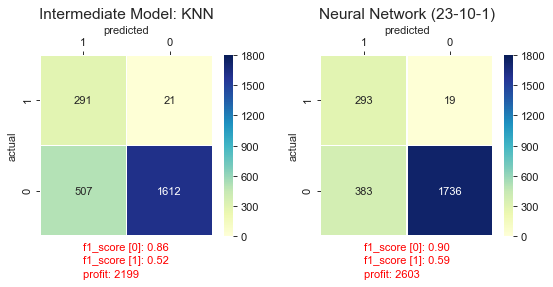

In [124]:
figmodelsCmpfinal = plt.figure(figsize = (8, 3), dpi = 80, facecolor = 'w', edgecolor = 'k', constrained_layout = False)
gsmodelsCmpfinal = gridspec.GridSpec(nrows = 1, ncols = 2, hspace = .65, wspace = .3, height_ratios = [1],\
                                     width_ratios = [1, 1], figure = figmodelsCmpfinal)
    
# best KNN model: modelKNN_3_5
list_vars = ['Recency_z', 'MntAdventure_z', 'NumCatalogPurchases_z', 'Income_z', 'NumWebVisitsMonth_z']
target = df_predictive['DepVar'].values
data = df_predictive[list_vars].values


# make the predictions with the threshold (use the custom function)
pred_fulldatasetKNN = f_model_pred_cost(modelKNN_3_5, data, theoretical_threshold)
f1_score_fulldatasetKNN = f1_score(target, pred_fulldatasetKNN, average = None) # evaluate the f1 score
f1_score_fulldatasetKNN_0 = f1_score_fulldatasetKNN[0]
f1_score_fulldatasetKNN_1 = f1_score_fulldatasetKNN[1]
df_CM_KNN = confusion_matrix(target, pred_fulldatasetKNN) # evaluate the confusion matrix
profit_KNN = df_CM_KNN[1, 1] * 13 - (df_CM_KNN[1, 0] * 3 + df_CM_KNN[0, 1] * 3) # this is the real profit

ax_model_KNN = plt.Subplot(figmodelsCmpfinal, gsmodelsCmpfinal[0, 0])
figmodelsCmpfinal.add_subplot(ax_model_KNN)

sns.heatmap(df_CM_KNN,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = 0, vmax = 1800,\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_KNN).set_title('Intermediate Model: KNN', size = 14)

ax_model_KNN.text(1.5, -.15, 'f1_score [0]: ' + '{:.2f}'.format(f1_score_fulldatasetKNN_0), color = 'red',\
                                                                  ha = 'left', fontsize = 10)
ax_model_KNN.text(1.5, -.3, 'f1_score [1]: ' + '{:.2f}'.format(f1_score_fulldatasetKNN_1), color = 'red',\
                                                              ha = 'left', fontsize = 10)
ax_model_KNN.text(1.5, -.45, 'profit: ' + '{:.0f}'.format(profit_KNN), color = 'red', ha = 'left', fontsize = 10)                     
ax_model_KNN.invert_xaxis()
ax_model_KNN.invert_yaxis()
ax_model_KNN.set_xlabel('predicted')
ax_model_KNN.set_ylabel('actual')
ax_model_KNN.xaxis.set_ticks_position('top')
ax_model_KNN.xaxis.set_label_position('top')
    
    

# best NN model: modelNN_3_23
list_vars = ['Recency_z', 'MntAdventure_z', 'NumCatalogPurchases_z', 'Income_z', 'NumWebVisitsMonth_z',\
             'NumDealsPurchases_z', 'MntTechnical_z', 'MntHardcover_z', 'MntTravelling_z', 'NumStorePurchases_z',\
             'MntRomance_z', 'Age_z', 'MntHistory_z',\
             'NumWebPurchases_z', 'MStatus_Together_flag', 'MStatus_Single_flag', 'Kidhome_0_flag', 'Kidhome_1_flag',\
             'MntTravelling_flag', 'MStatus_Divorced_flag', 'Education_Graduation_flag', 'MStatus_Widow_flag',\
             'MntRomance_flag']
target = df_predictive['DepVar'].values
data = df_predictive[list_vars].values


# make the predictions with the threshold (use the custom function)
pred_fulldatasetNN = f_model_pred_cost(modelNN_3_23, data, theoretical_threshold)
f1_score_fulldatasetNN = f1_score(target, pred_fulldatasetNN, average = None) # evaluate the f1 score
f1_score_fulldatasetNN_0 = f1_score_fulldatasetNN[0]
f1_score_fulldatasetNN_1 = f1_score_fulldatasetNN[1]
df_CM_NN = confusion_matrix(target, pred_fulldatasetNN) # evaluate the confusion matrix
profit_NN = df_CM_NN[1, 1] * 13 - (df_CM_NN[1, 0] * 3 + df_CM_NN[0, 1] * 3) # this is the real profit

ax_model_NN = plt.Subplot(figmodelsCmpfinal, gsmodelsCmpfinal[0, 1])
figmodelsCmpfinal.add_subplot(ax_model_NN)

sns.heatmap(df_CM_NN,  annot = True, fmt = '.0f', cmap = 'YlGnBu', vmin = 0, vmax = 1800,\
                    linewidths = .5, cbar = {'shrink': .75, 'label': 'Record Counts'},\
                    ax = ax_model_NN).set_title('Neural Network (23-10-1)', size = 14)

ax_model_NN.text(1.5, -.15, 'f1_score [0]: ' + '{:.2f}'.format(f1_score_fulldatasetNN_0), color = 'red',\
                                                                  ha = 'left', fontsize = 10)
ax_model_NN.text(1.5, -.3, 'f1_score [1]: ' + '{:.2f}'.format(f1_score_fulldatasetNN_1), color = 'red',\
                                                              ha = 'left', fontsize = 10)
ax_model_NN.text(1.5, -.45, 'profit: ' + '{:.0f}'.format(profit_NN), color = 'red', ha = 'left', fontsize = 10)                                
ax_model_NN.invert_xaxis()
ax_model_NN.invert_yaxis()
ax_model_NN.set_xlabel('predicted')
ax_model_NN.set_ylabel('actual')
ax_model_NN.xaxis.set_ticks_position('top')
ax_model_NN.xaxis.set_label_position('top')

   ><p> In the end it appears that the Neural Network (23-10-1) still outperforms the Intermediate KNN model and, therefore, this will be our choice as the best predictive model.</p>

[Return to Table of Contents](#Table_Contents)